In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
sns.set()
%matplotlib inline

import time
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.options.display.float_format = '{:.2f}'.format

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# Loading the dataset and making a copy
dataset = pd.read_excel('C:/Users/HP/Desktop/Study/DSA8023/DSA8023 - Bhavana Pansare/System-Data-Qtr-Hourly-2022-2023_0.xlsx')
df = dataset.copy()

In [3]:
# Display the shape of Dataframe
df.shape

(70080, 37)

### Data Preprocessing

#### Creating Net Demand as difference between Total Demand and Total Generation(all renewable energy sources) 

In [4]:
# Calculate 'AI Net Demand' by subtracting wind, solar, and hydro generation from total AI demand.
df['AI Net Demand'] = df['AI Demand'] - df['AI Wind Generation'] - df['AI Solar Generation'] - df['AI Hydro']
# Calculate 'IE Net Demand' by subtracting wind, solar, and hydro generation from total IE demand.
df['IE Net Demand'] = df['IE Demand'] - df['IE Wind Generation'] - df['IE Solar Generation'] - df['IE Hydro']
# Calculate 'NI Net Demand' by subtracting wind and solar generation from total NI demand.
df['NI Net Demand'] = df['NI Demand'] - df['NI Wind Generation'] - df['NI Solar Generation']

In [5]:
# Display a summary of Dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70080 entries, 0 to 70079
Data columns (total 40 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   DateTime                                            70080 non-null  datetime64[ns]
 1   GMT Offset                                          70080 non-null  int64         
 2   NI Generation                                       70080 non-null  float64       
 3   NI Demand                                           70080 non-null  float64       
 4   NI Wind Availability                                70080 non-null  float64       
 5   NI Wind Generation                                  70080 non-null  float64       
 6   NI Solar Availability                               70080 non-null  float64       
 7   NI Solar Generation                                 70080 non-null  float64       
 8   Moyle 

#### Trading day (23:00 on the prior day → 22:59 on the subsequent day), hour and min columns

In [6]:
# Define 'Trading Day' based on the 'DateTime' column. 
# If the hour is before 23:00, use the same day as 'Trading Day'. 
# If the hour is 23:00 or later, assign the next calendar day as 'Trading Day'.
df['Trading Day'] = df['DateTime'].apply(lambda x: x.date() if x.hour < 23 else (x + pd.Timedelta(days=1)).date())

In [7]:
# Group by 'Trading Day', count entries per day to validate Trading day is calculated perfectly.
df.groupby(['Trading Day']).agg({'Trading Day':'count'}).rename(columns={'Trading Day':'No of records'}).reset_index()

,Trading Day,No of records
0,2022-01-01,92
1,2022-01-02,96
2,2022-01-03,96
3,2022-01-04,96
4,2022-01-05,96
...,...,...
726,2023-12-28,96
727,2023-12-29,96
728,2023-12-30,96
729,2023-12-31,96


In [8]:
# Extracting the hour component from 'DateTime' for time based analysis.
df['hour'] = df['DateTime'].apply(lambda x: x.hour)
# Categorizing minutes into 'First 30' and 'Second 30' intervals for detailed time analysis.
df['min'] = df['DateTime'].apply(lambda x: 'First 30' if x.minute==0 or x.minute==15 else 'Second 30')

In [9]:
# Display the first 5 records
df.head()

,DateTime,GMT Offset,NI Generation,NI Demand,NI Wind Availability,NI Wind Generation,NI Solar Availability,NI Solar Generation,Moyle I/C,NI Wind Penetration,...,SNSP,Unnamed: 34,Unnamed: 35,NI: Northern Ireland \nIE: Ireland \nAI: All Island,AI Net Demand,IE Net Demand,NI Net Demand,Trading Day,hour,min
0,2022-01-01 00:00:00,0,959.38,598.23,886.60,596.15,0.00,0.00,-321.93,1.00,...,0.69,NaN,NaN,Notes: \nThe system data in this report is is ...,459.66,457.59,2.07,2022-01-01,0,First 30
1,2022-01-01 00:15:00,0,961.81,581.95,893.69,596.55,0.00,0.00,-322.93,1.03,...,0.69,NaN,NaN,NaN,407.33,421.92,-14.59,2022-01-01,0,First 30
2,2022-01-01 00:30:00,0,958.66,566.31,911.39,599.37,0.00,0.00,-323.00,1.06,...,0.69,NaN,NaN,NaN,387.61,420.68,-33.07,2022-01-01,0,Second 30
3,2022-01-01 00:45:00,0,963.78,555.97,927.90,600.44,0.00,0.00,-323.13,1.08,...,0.70,NaN,NaN,NaN,293.04,337.51,-44.47,2022-01-01,0,Second 30
4,2022-01-01 01:00:00,0,973.50,569.45,916.00,605.22,0.00,0.00,-322.27,1.06,...,0.70,NaN,NaN,NaN,159.86,195.63,-35.77,2022-01-01,1,First 30


In [10]:
# Display column names
df.columns

Index(['DateTime', 'GMT Offset', 'NI Generation', 'NI Demand',
       'NI Wind Availability', 'NI Wind Generation', 'NI Solar Availability',
       'NI Solar Generation', 'Moyle I/C', 'NI Wind Penetration',
       'NI Solar Penetration', 'IE Generation', 'IE Demand',
       'IE Wind Availability', 'IE Wind Generation', 'IE Solar Availability',
       'IE Solar Generation', 'IE Hydro', 'EWIC I/C', 'IE Wind Penetration',
       'IE Solar Penetration', 'AI Generation', 'AI Demand',
       'AI Wind Availability', 'AI Wind Generation', 'AI Solar Availability',
       'AI Solar Generation', 'AI Hydro', 'Inter-Jurisdictional Flow',
       'AI Wind Penetration', 'AI Solar Penetration', 'AI Oversupply',
       'AI Oversupply Percentage', 'SNSP', 'Unnamed: 34', 'Unnamed: 35',
       'NI: Northern Ireland \nIE: Ireland \nAI: All Island ', 'AI Net Demand',
       'IE Net Demand', 'NI Net Demand', 'Trading Day', 'hour', 'min'],
      dtype='object')

### Wind Generation - Graphs


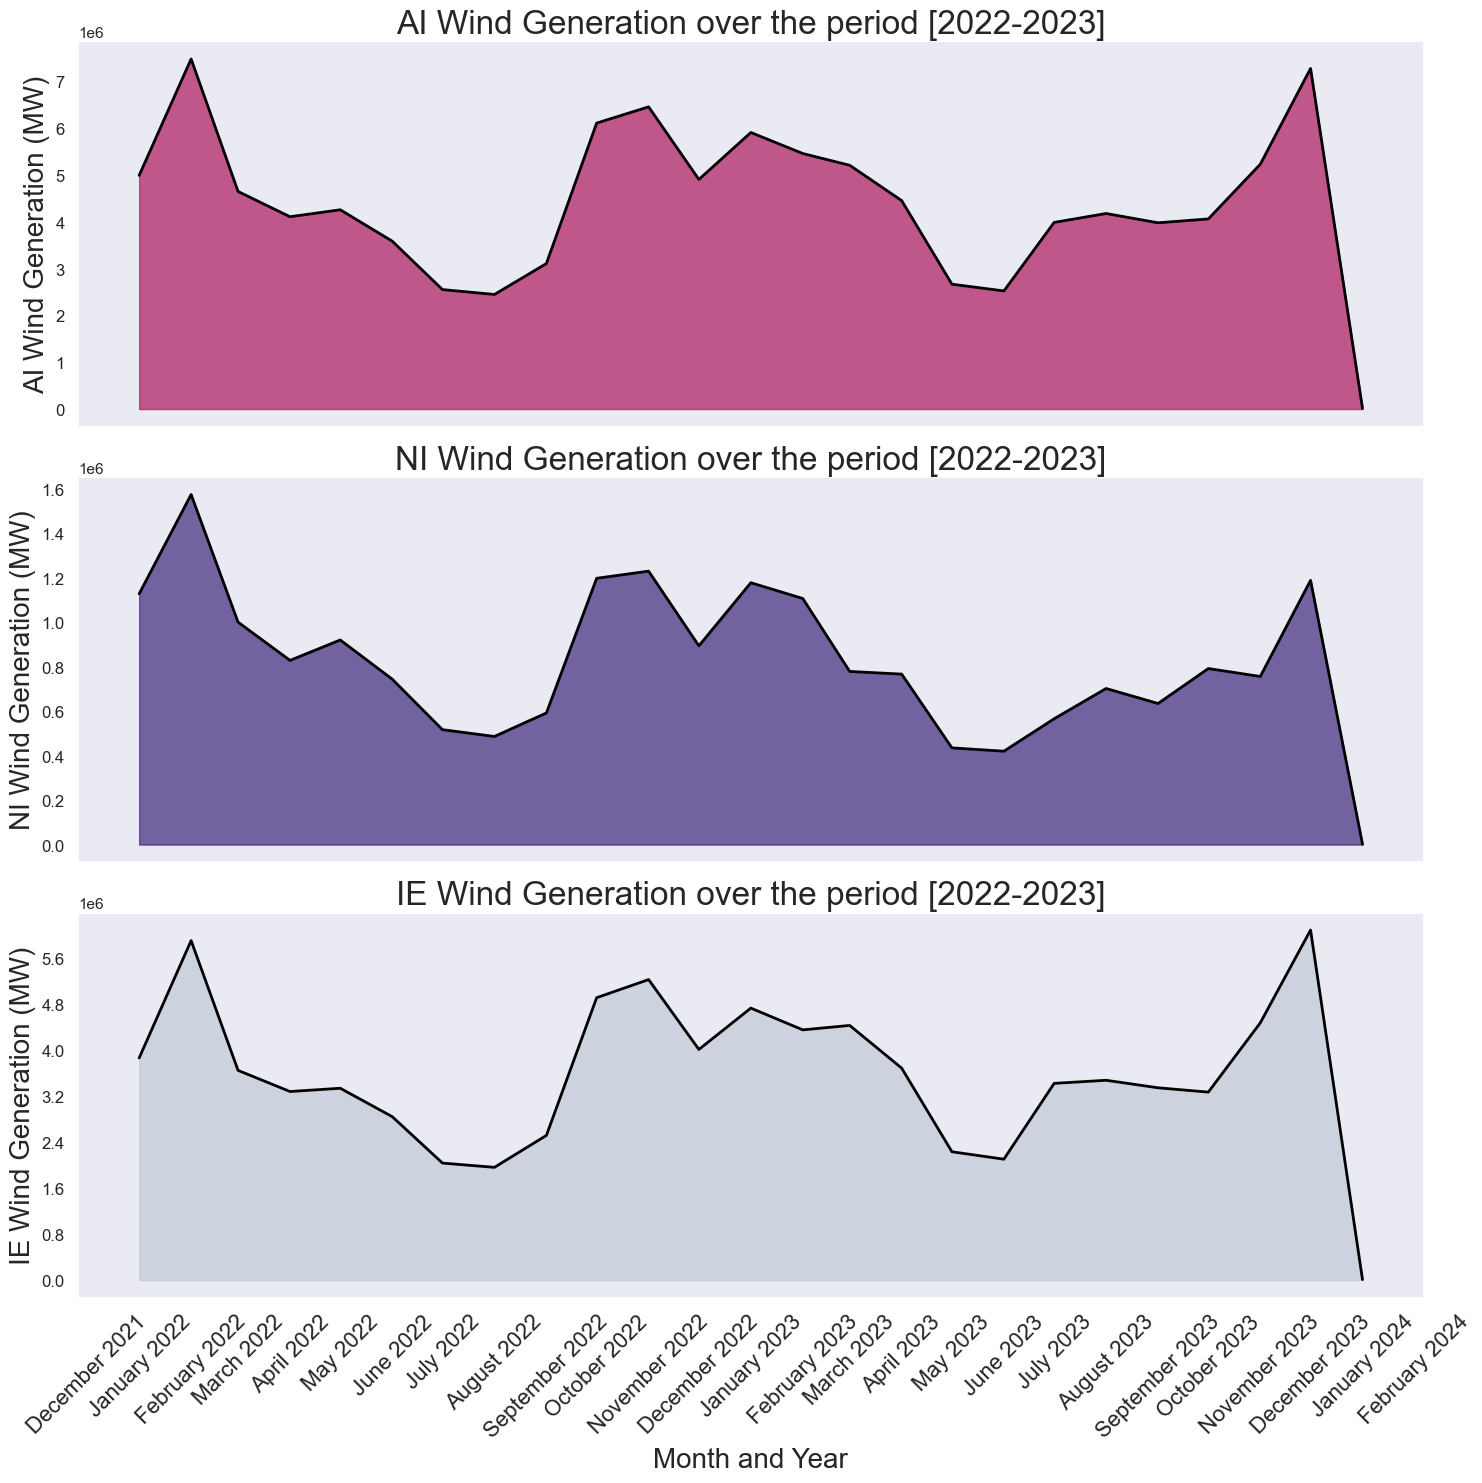

In [11]:
# Convert 'Trading Day' column to datetime
df['Trading Day'] = pd.to_datetime(df['Trading Day'])

# Group the data by month for each region
df['MonthYear'] = df['Trading Day'].dt.to_period('M')

# Summing up wind generation for each month and region
monthly_ai = df.groupby('MonthYear')['AI Wind Generation'].sum().reset_index()
monthly_ni = df.groupby('MonthYear')['NI Wind Generation'].sum().reset_index()
monthly_ie = df.groupby('MonthYear')['IE Wind Generation'].sum().reset_index()

# Convert 'MonthYear' back to timestamp for plotting
monthly_ai['MonthYear'] = monthly_ai['MonthYear'].dt.to_timestamp()
monthly_ni['MonthYear'] = monthly_ni['MonthYear'].dt.to_timestamp()
monthly_ie['MonthYear'] = monthly_ie['MonthYear'].dt.to_timestamp()

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(15, 15), sharex=True)

# AI Wind Generation Plot
axs[0].fill_between(monthly_ai['MonthYear'], monthly_ai['AI Wind Generation'], color='#af195f', alpha = 0.7)
axs[0].plot(monthly_ai['MonthYear'], monthly_ai['AI Wind Generation'], color='black', linewidth=2)
axs[0].set_title('AI Wind Generation over the period [2022-2023]',fontsize=24)
axs[0].set_ylabel('AI Wind Generation (MW)',fontsize=20)
axs[0].tick_params(axis='y', labelsize=12) 
axs[0].yaxis.set_major_locator(MaxNLocator(integer=True))
axs[0].grid(False)

# NI Wind Generation Plot
axs[1].fill_between(monthly_ni['MonthYear'], monthly_ni['NI Wind Generation'], color='#3F2A7D', alpha = 0.7)
axs[1].plot(monthly_ni['MonthYear'], monthly_ni['NI Wind Generation'], color='black', linewidth=2)
axs[1].set_title('NI Wind Generation over the period [2022-2023]',fontsize=24)
axs[1].set_ylabel('NI Wind Generation (MW)',fontsize=20)
axs[1].tick_params(axis='y', labelsize=12) 
axs[1].yaxis.set_major_locator(MaxNLocator(integer=True))
axs[1].grid(False)

# IE Wind Generation Plot
axs[2].fill_between(monthly_ie['MonthYear'], monthly_ie['IE Wind Generation'], color='#C0CAD6', alpha = 0.7)
axs[2].plot(monthly_ie['MonthYear'], monthly_ie['IE Wind Generation'], color='black', linewidth=2)
axs[2].set_title('IE Wind Generation over the period [2022-2023]',fontsize=24)
axs[2].set_ylabel('IE Wind Generation (MW)',fontsize=20)
axs[2].tick_params(axis='y', labelsize=12) 
axs[2].yaxis.set_major_locator(MaxNLocator(integer=True))
axs[2].grid(False)

# Formatting the x-axis to show months properly
plt.xticks(rotation=45, fontsize=16) 
plt.yticks(fontsize=12)  
axs[-1].xaxis.set_major_formatter(mdates.DateFormatter('%B %Y'))
axs[-1].xaxis.set_major_locator(mdates.MonthLocator())

# Labels for the figure
plt.xlabel('Month and Year',fontsize=20)
plt.tight_layout()
plt.show()

# For saving as a JPG
fig.savefig('C:/Users/HP/Desktop/Study/DSA8023/DSA8023 - Bhavana Pansare/monthly_wind_generation.jpg', format='jpg');


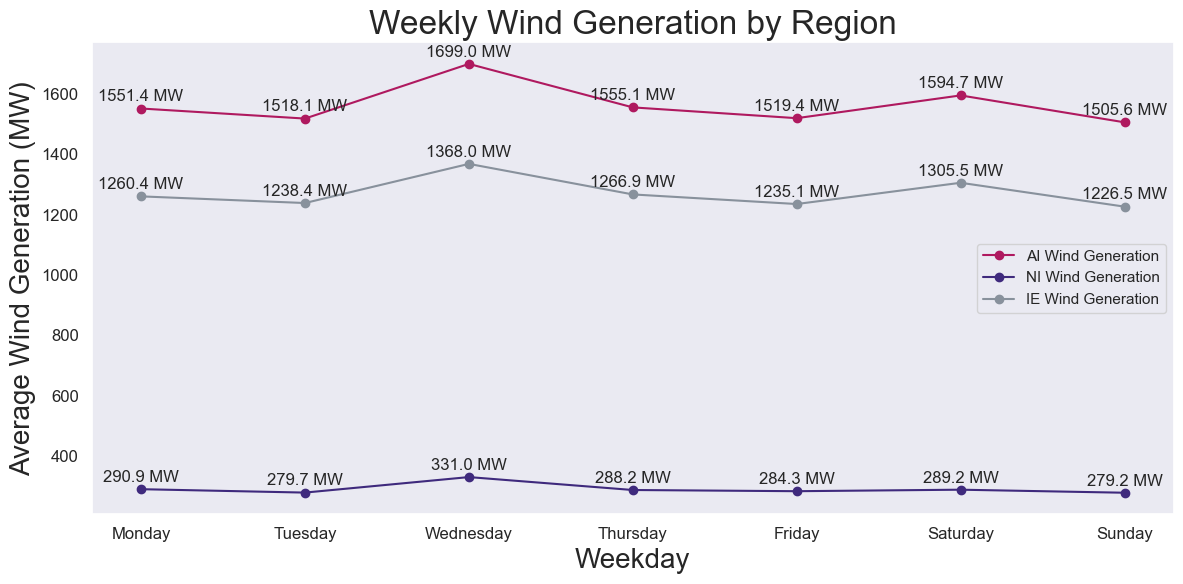

In [12]:
# Calculate the day of the week from 'Trading Day'
df['Trading Day'] = pd.to_datetime(df['Trading Day'])
df['Weekday'] = df['Trading Day'].dt.day_name()

# Define a function to add value annotations
def add_value_annotations(ax, lines):
    for line in lines:
        y_values = line.get_ydata()
        for i, y in enumerate(y_values):
            ax.annotate(f'{y:.1f} MW',
                        xy=(i, y),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
            
# Reset the index without keeping the column
df.reset_index(drop=True, inplace=True)

# Group by the day of the week and calculate the average wind generation for each region
avg_wind_gen = df.groupby('Weekday')[['AI Wind Generation', 'NI Wind Generation', 'IE Wind Generation']].mean()

# Define an ordered list of weekdays
week_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Reorder the weekdays
avg_wind_gen = avg_wind_gen.reindex(week_days)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the average wind generation for each region with specified colors
lines_ai = ax.plot(avg_wind_gen.index, avg_wind_gen['AI Wind Generation'], marker='o', color='#af195f', label='AI Wind Generation')
lines_ni = ax.plot(avg_wind_gen.index, avg_wind_gen['NI Wind Generation'], marker='o', color='#3F2A7D', label='NI Wind Generation')
lines_ie = ax.plot(avg_wind_gen.index, avg_wind_gen['IE Wind Generation'], marker='o', color='#88919C', label='IE Wind Generation')

# Add value annotations
add_value_annotations(ax, lines_ai)
add_value_annotations(ax, lines_ni)
add_value_annotations(ax, lines_ie)

# Add labels and title
ax.set_xlabel('Weekday',fontsize=20)
ax.set_ylabel('Average Wind Generation (MW)',fontsize=20)
ax.set_title('Weekly Wind Generation by Region',fontsize=24)
ax.grid(False)
ax.tick_params(axis='y', labelsize=12) 
ax.tick_params(axis='x', labelsize=12) 
ax.legend()

# Show plot
plt.tight_layout()
plt.show()

# For saving as a JPG
fig.savefig('C:/Users/HP/Desktop/Study/DSA8023/DSA8023 - Bhavana Pansare/weekly_wind_generation.jpg', format='jpg');

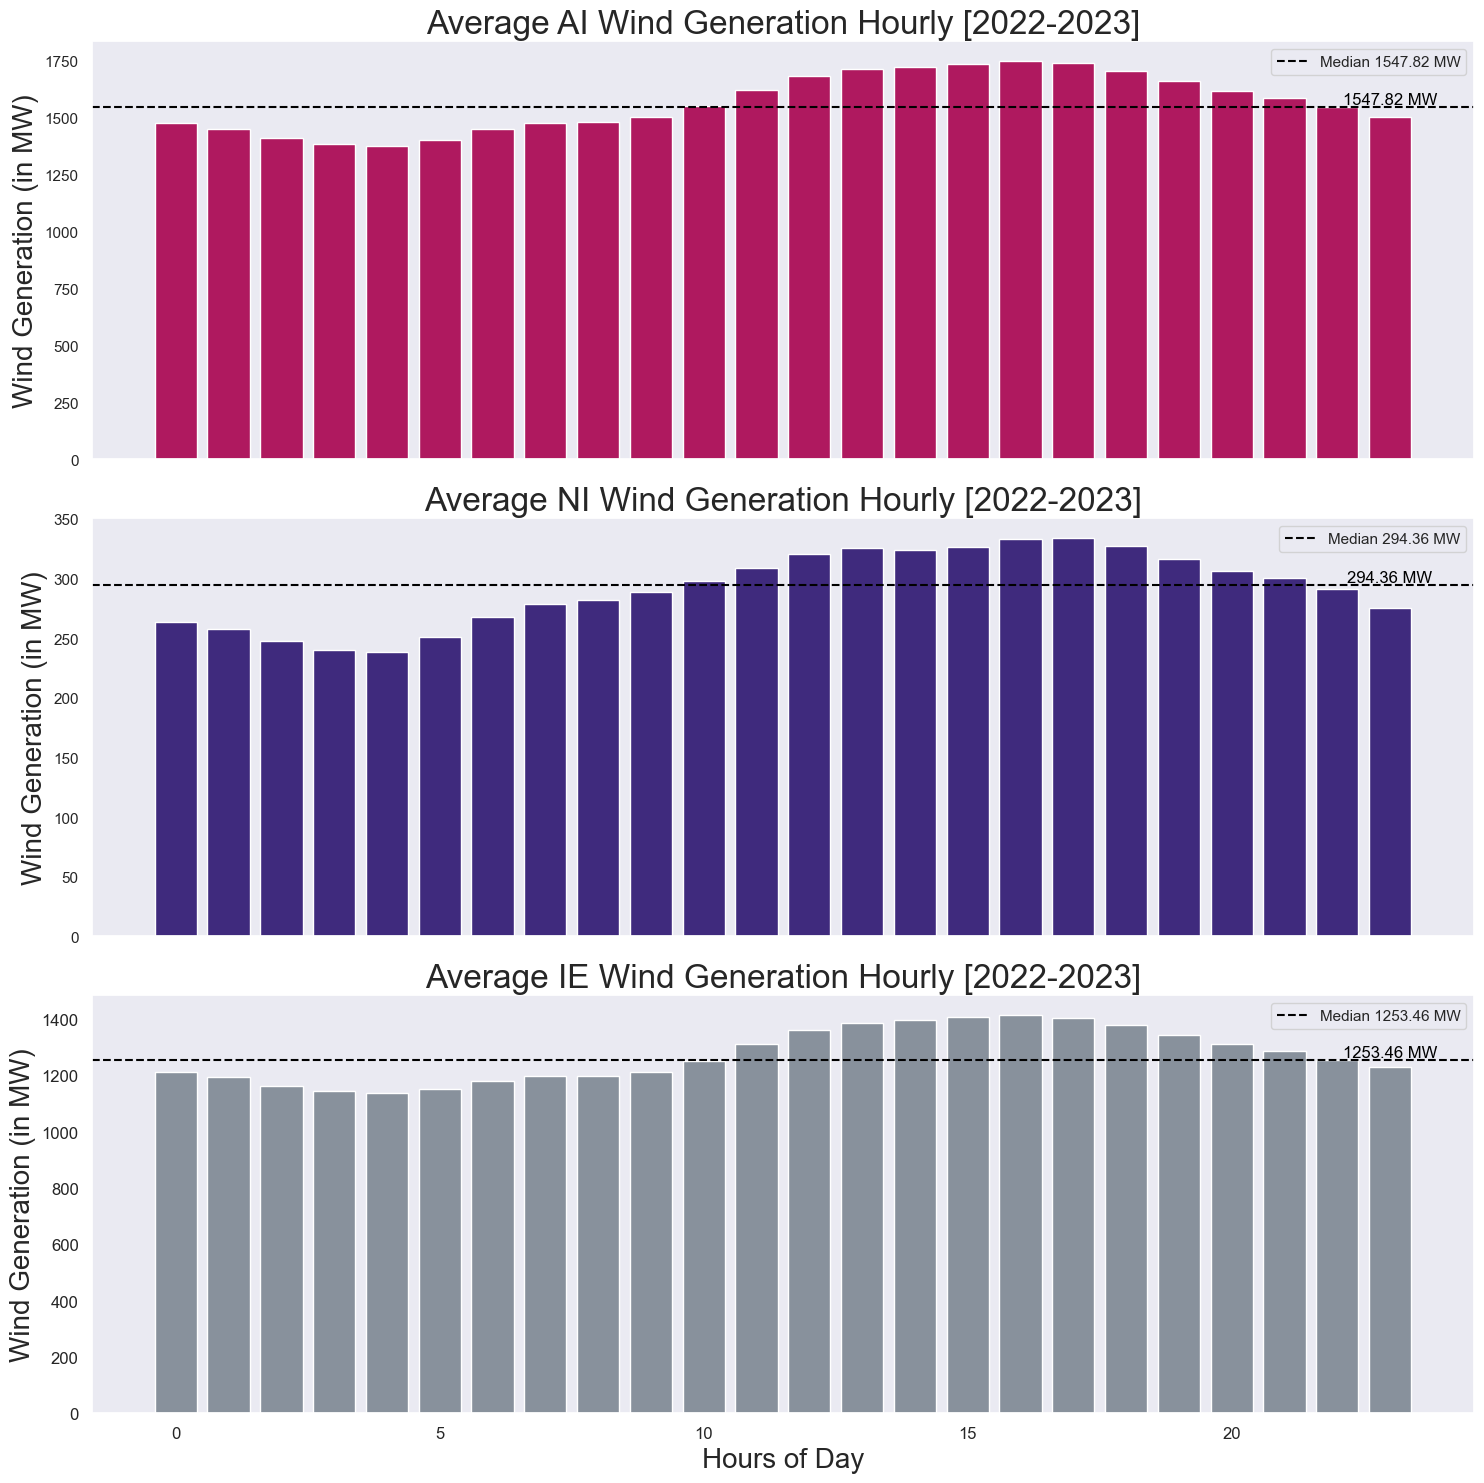

In [13]:
colors = ['#af195f', '#3F2A7D', '#88919C']
# Calculate the hour from 'DateTime'
df['Hour'] = df['DateTime'].dt.hour

# Create subplots for each region
fig, axs = plt.subplots(3, 1, figsize=(15, 15), sharex=True)

# Calculate the average wind generation by hour for each region
for i, region in enumerate(['AI Wind Generation', 'NI Wind Generation', 'IE Wind Generation']):
    avg_wind_generation_by_hour = df.groupby('Hour')[region].mean()
    median_value = avg_wind_generation_by_hour.median()
    
    # Plotting the bar chart for the region
    bars = axs[i].bar(avg_wind_generation_by_hour.index, avg_wind_generation_by_hour.values, color=colors[i])
    
    # Draw the median line
    axs[i].axhline(y=median_value, color='black', linestyle='dashed', label=f'Median {median_value:.2f} MW')
    
    # Add the median value as text on the plot
    axs[i].text(23, median_value, f'{median_value:.2f} MW', color='black', ha='center', va='bottom')
    
    # Set title, labels for each subplot
    axs[i].set_title(f'Average {region.split()[0]} Wind Generation Hourly [2022-2023]',fontsize=24)
    axs[i].set_ylabel('Wind Generation (in MW)',fontsize=20)
    axs[i].grid(False)
    
    # Show the legend
    axs[i].legend()

# Set common x-axis label
axs[-1].set_xlabel('Hours of Day',fontsize=20)

# Set xticks and yticks font size to 12
axs[i].tick_params(axis='x', labelsize=12)
axs[i].tick_params(axis='y', labelsize=12)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

# For saving as a JPG
fig.savefig('C:/Users/HP/Desktop/Study/DSA8023/DSA8023 - Bhavana Pansare/hourly_wind_generation.jpg', format='jpg');

### Demand - Graphs

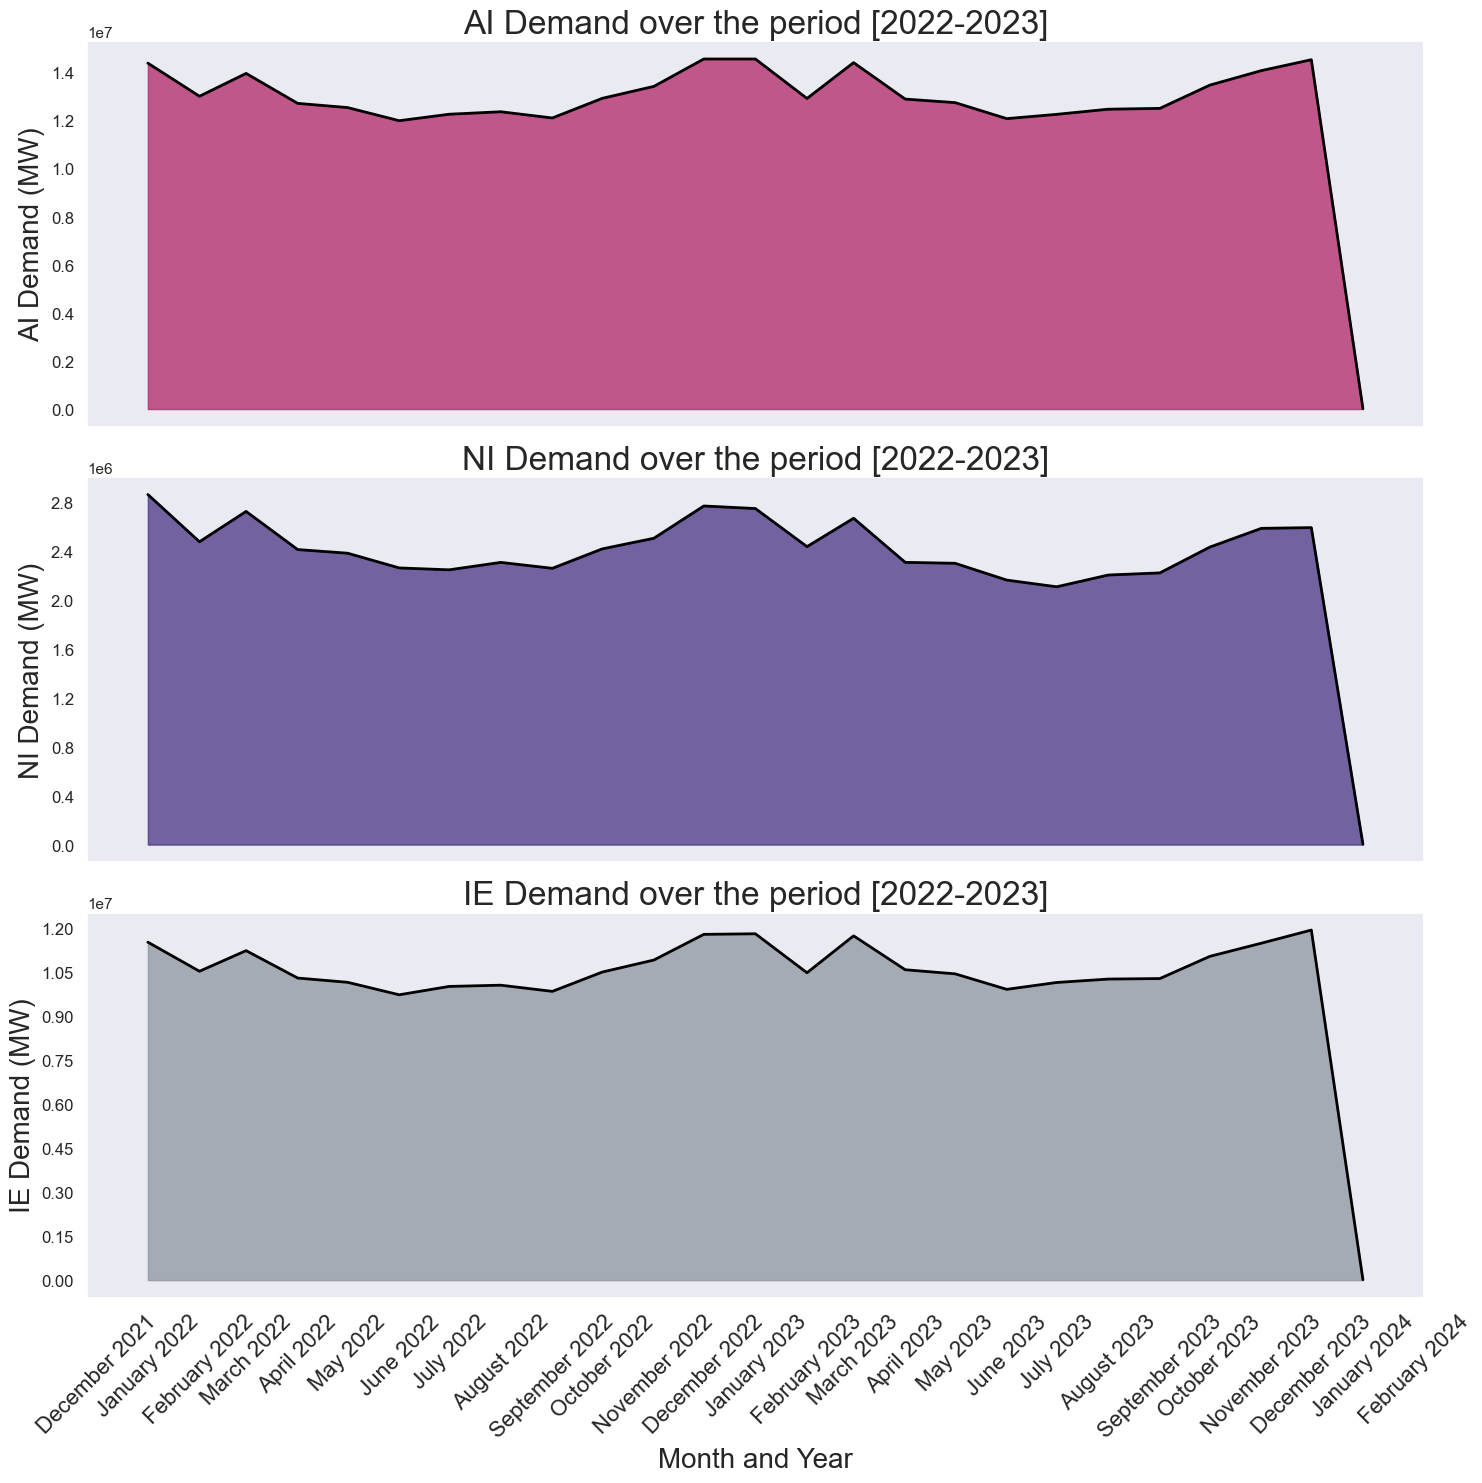

In [14]:
# Convert 'Trading Day' column to datetime
df['Trading Day'] = pd.to_datetime(df['Trading Day'])

# Group the data by month for each region
df['MonthYear'] = df['Trading Day'].dt.to_period('M')

# Summing up demand for each month and region
monthly_ai = df.groupby('MonthYear')['AI Demand'].sum().reset_index()
monthly_ni = df.groupby('MonthYear')['NI Demand'].sum().reset_index()
monthly_ie = df.groupby('MonthYear')['IE Demand'].sum().reset_index()

# Convert 'MonthYear' back to timestamp for plotting
monthly_ai['MonthYear'] = monthly_ai['MonthYear'].dt.to_timestamp()
monthly_ni['MonthYear'] = monthly_ni['MonthYear'].dt.to_timestamp()
monthly_ie['MonthYear'] = monthly_ie['MonthYear'].dt.to_timestamp()

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(15, 15), sharex=True)

# AI Demand Plot
axs[0].fill_between(monthly_ai['MonthYear'], monthly_ai['AI Demand'], color='#af195f', alpha = 0.7)
axs[0].plot(monthly_ai['MonthYear'], monthly_ai['AI Demand'], color='black', linewidth=2)
axs[0].set_title('AI Demand over the period [2022-2023]',fontsize=24)
axs[0].yaxis.set_major_locator(MaxNLocator(integer=True))
axs[0].set_ylabel('AI Demand (MW)',fontsize=20)
axs[0].tick_params(axis='y', labelsize=12) 
axs[0].grid(False)

# NI Demand Plot
axs[1].fill_between(monthly_ni['MonthYear'], monthly_ni['NI Demand'], color='#3F2A7D', alpha = 0.7)
axs[1].plot(monthly_ni['MonthYear'], monthly_ni['NI Demand'], color='black', linewidth=2)
axs[1].set_title('NI Demand over the period [2022-2023]',fontsize=24)
axs[1].yaxis.set_major_locator(MaxNLocator(integer=True))
axs[1].set_ylabel('NI Demand (MW)',fontsize=20)
axs[1].tick_params(axis='y', labelsize=12) 
axs[1].grid(False)

# IE Demand Plot
axs[2].fill_between(monthly_ie['MonthYear'], monthly_ie['IE Demand'], color='#88919C', alpha = 0.7)
axs[2].plot(monthly_ie['MonthYear'], monthly_ie['IE Demand'], color='black', linewidth=2)
axs[2].set_title('IE Demand over the period [2022-2023]',fontsize=24)
axs[2].yaxis.set_major_locator(MaxNLocator(integer=True))
axs[2].set_ylabel('IE Demand (MW)',fontsize=20)
axs[2].tick_params(axis='y', labelsize=12) 
axs[2].grid(False)

# Format the x-axis to show months properly
plt.xticks(rotation=45, fontsize=16) 
plt.yticks(fontsize=12)
axs[-1].xaxis.set_major_formatter(mdates.DateFormatter('%B %Y'))
axs[-1].xaxis.set_major_locator(mdates.MonthLocator())

# Labels of figure
plt.xlabel('Month and Year',fontsize=20)
plt.tight_layout()
plt.show()

# For saving as a JPG
fig.savefig('C:/Users/HP/Desktop/Study/DSA8023/DSA8023 - Bhavana Pansare/monthly_demand.jpg', format='jpg');

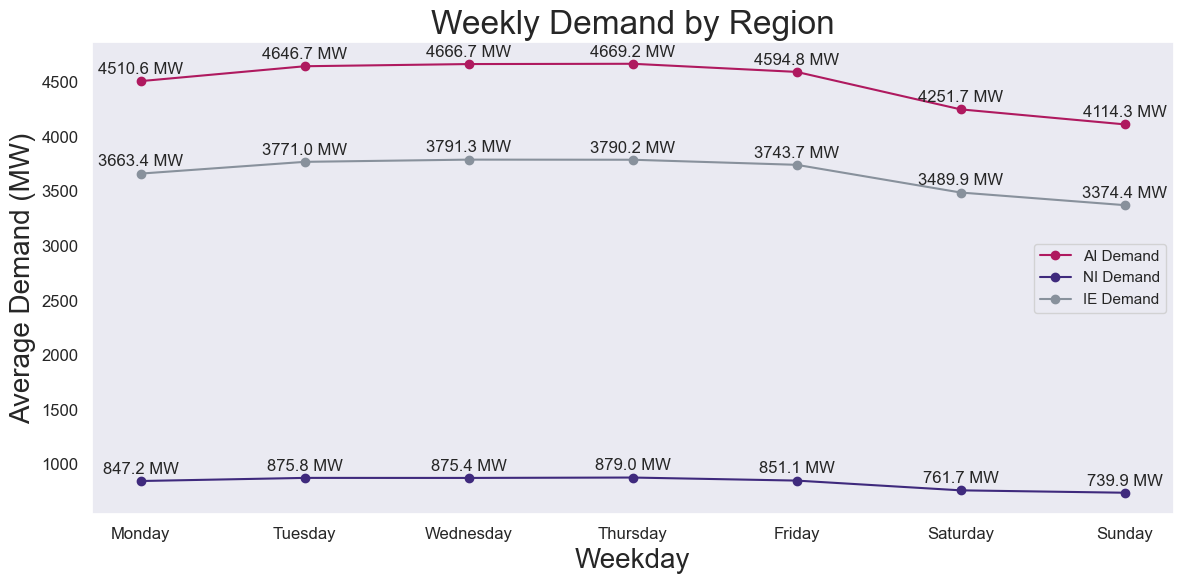

In [15]:
# Calculate the day of the week from 'Trading Day'
df['Trading Day'] = pd.to_datetime(df['Trading Day'])
df['Weekday'] = df['Trading Day'].dt.day_name()

# Define a function to add value annotations
def add_value_annotations(ax, lines):
    for line in lines:
        y_values = line.get_ydata()
        for i, y in enumerate(y_values):
            ax.annotate(f'{y:.1f} MW',
                        xy=(i, y),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

# Reset the index without keeping the column
df.reset_index(drop=True, inplace=True)

# Group by the day of the week and calculate the average Demand for each region
avg_demand = df.groupby('Weekday')[['AI Demand', 'NI Demand', 'IE Demand']].mean()

# Define an ordered list of weekdays
week_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Reorder the weekdays
avg_demand = avg_demand.reindex(week_days)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the average demand for each region with specified colors
lines_ai = ax.plot(avg_demand.index, avg_demand['AI Demand'], marker='o', color='#af195f', label='AI Demand')
lines_ni = ax.plot(avg_demand.index, avg_demand['NI Demand'], marker='o', color='#3F2A7D', label='NI Demand')
lines_ie = ax.plot(avg_demand.index, avg_demand['IE Demand'], marker='o', color='#88919C', label='IE Demand')


# Add value annotations
add_value_annotations(ax, lines_ai)
add_value_annotations(ax, lines_ni)
add_value_annotations(ax, lines_ie)


# Add labels and title
ax.set_xlabel('Weekday',fontsize=20)
ax.set_ylabel('Average Demand (MW)',fontsize=20)
ax.set_title('Weekly Demand by Region',fontsize=24)
ax.grid(False)
ax.tick_params(axis='y', labelsize=12) 
ax.tick_params(axis='x', labelsize=12) 
ax.legend()

# Show plot
plt.tight_layout()
plt.show()

# For saving as a JPG
fig.savefig('C:/Users/HP/Desktop/Study/DSA8023/DSA8023 - Bhavana Pansare/weekly_demand.jpg', format='jpg');

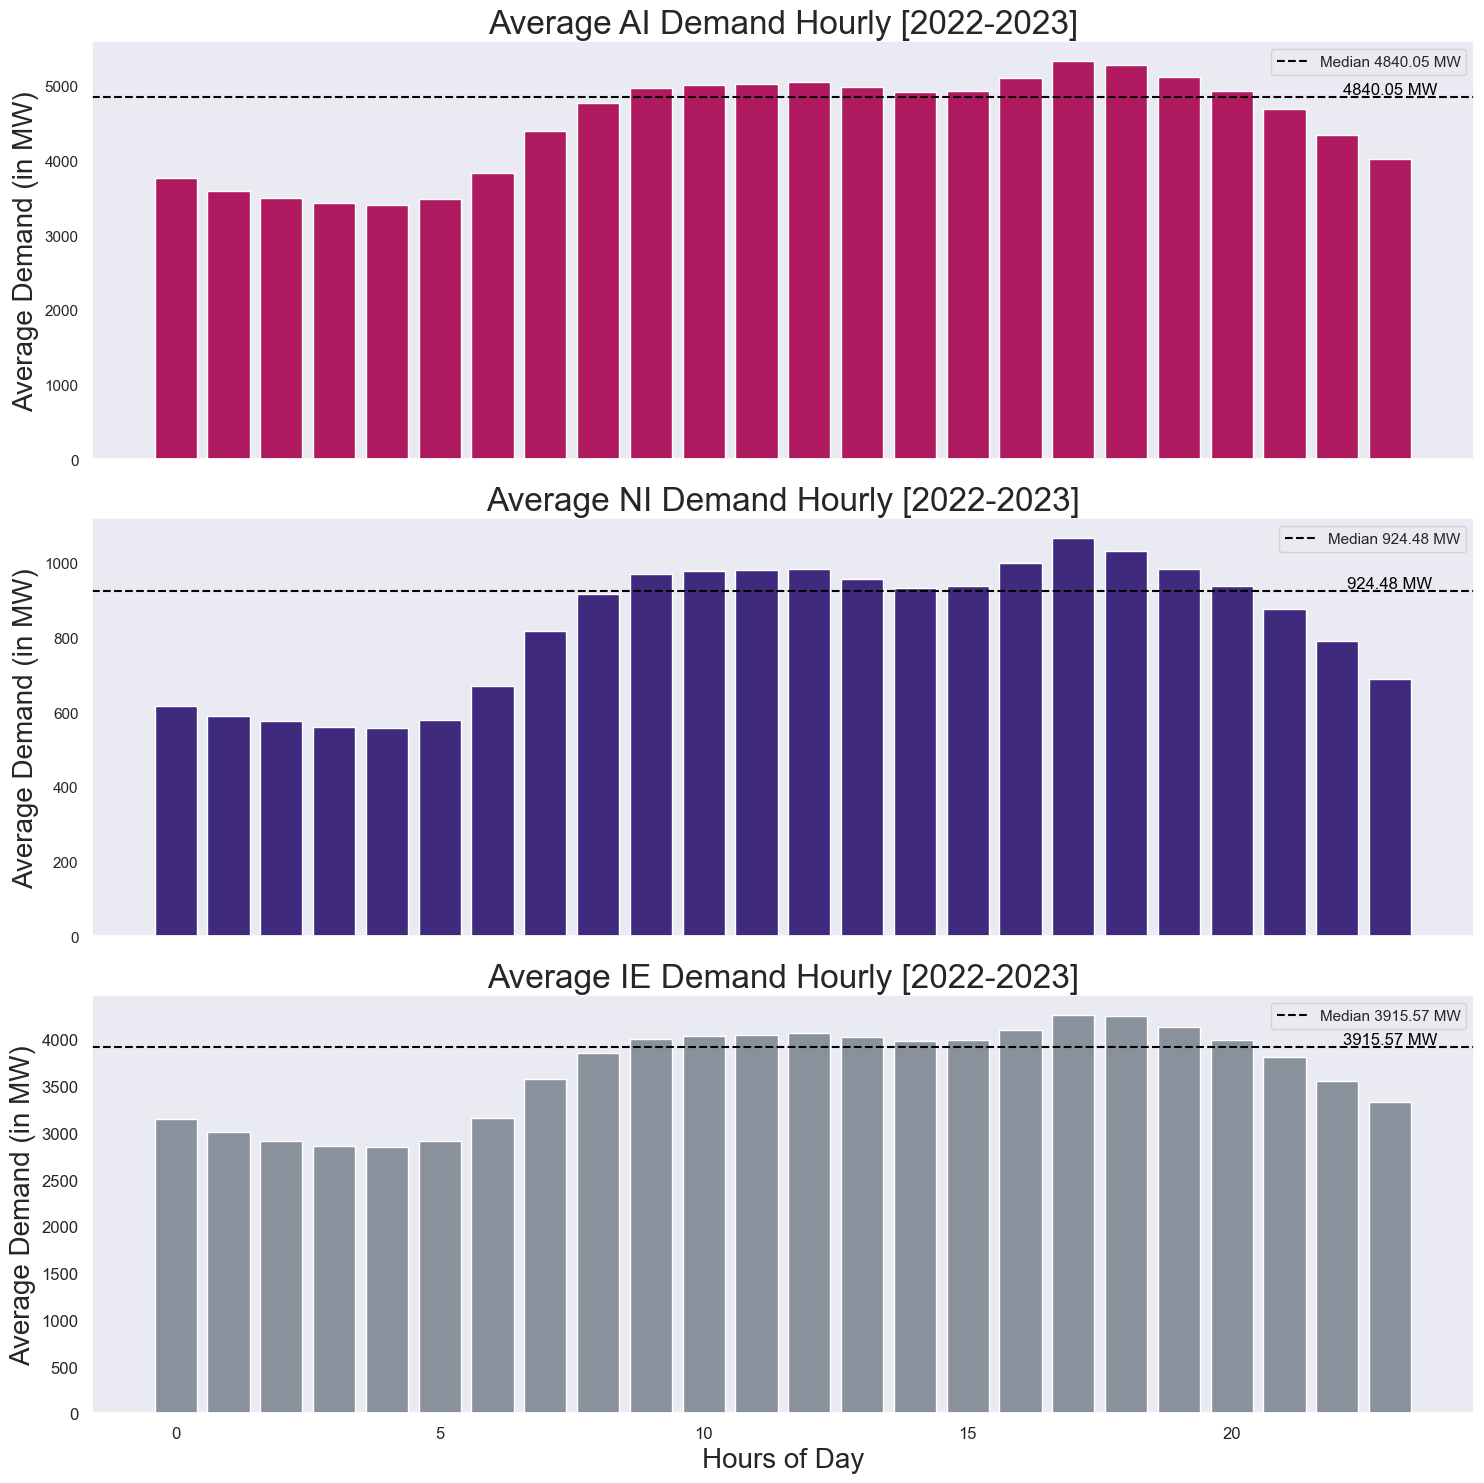

In [16]:
colors = ['#af195f', '#3F2A7D', '#88919C']
# Calculate the hour from 'DateTime'
df['Hour'] = df['DateTime'].dt.hour

# Create subplots for each region sharing only the x-axis
fig, axs = plt.subplots(3, 1, figsize=(15, 15), sharex=True)

# Calculate the average demand by hour for each region
for i, region in enumerate(['AI Demand', 'NI Demand', 'IE Demand']):
    avg_demand_by_hour = df.groupby('Hour')[region].mean()
    median_value = avg_demand_by_hour.median()
    
    # Plotting the bar chart for the region
    bars = axs[i].bar(avg_demand_by_hour.index, avg_demand_by_hour.values, color=colors[i])
    
    # Drawing the median line
    axs[i].axhline(y=median_value, color='black', linestyle='dashed', label=f'Median {median_value:.2f} MW')
    
    # Add the median value as text on the plot
    axs[i].text(23, median_value, f'{median_value:.2f} MW', color='black', ha='center', va='bottom')
    
    # Set title, labels for each subplot
    axs[i].set_title(f'Average {region.split()[0]} Demand Hourly [2022-2023]',fontsize=24)
    axs[i].set_ylabel('Average Demand (in MW)',fontsize=20)
    axs[i].grid(False)
    
    # Show the legend
    axs[i].legend()

# Set common x-axis label
axs[-1].set_xlabel('Hours of Day',fontsize=20)

# Set xticks and yticks font size to 12
axs[i].tick_params(axis='x', labelsize=12)
axs[i].tick_params(axis='y', labelsize=12)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

# For saving as a JPG
fig.savefig('C:/Users/HP/Desktop/Study/DSA8023/DSA8023 - Bhavana Pansare/hourly_demand.jpg', format='jpg');


### Net Demand - Graphs

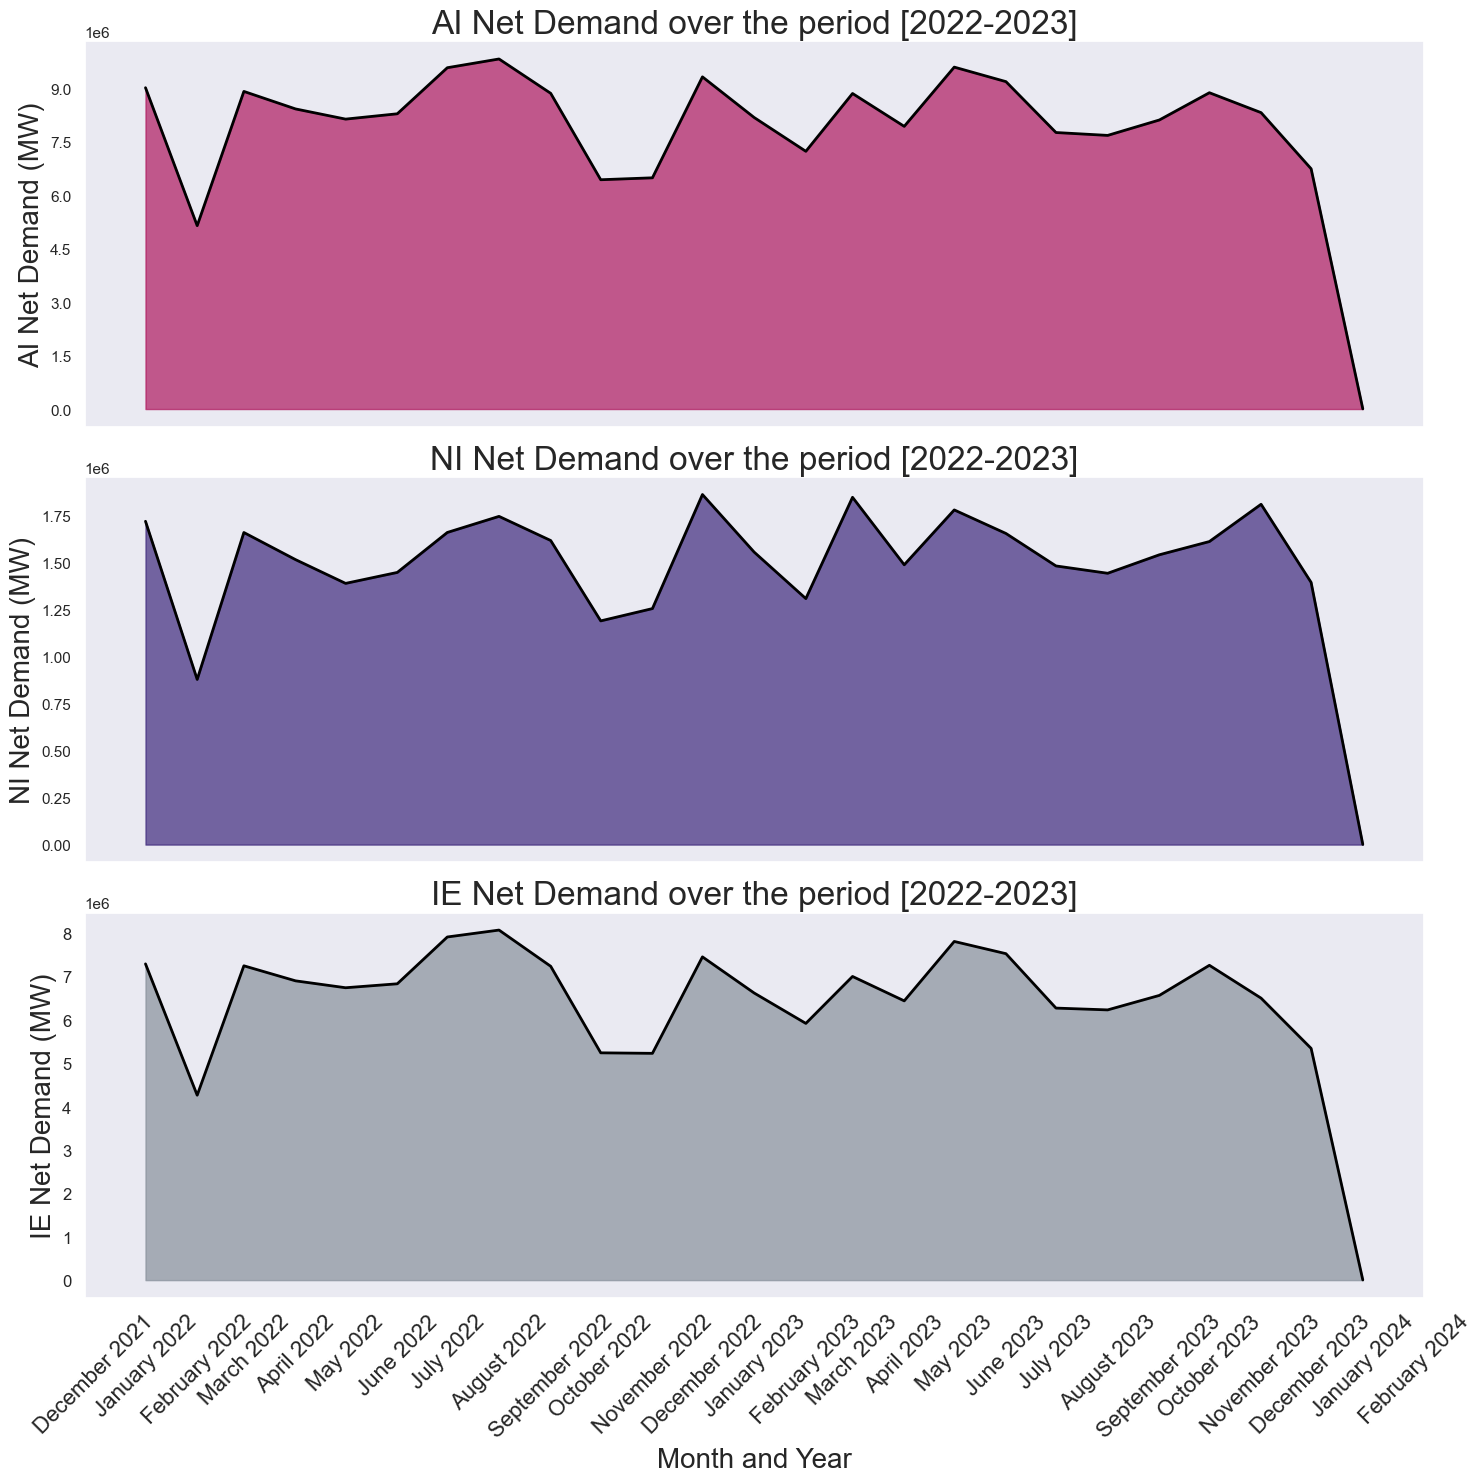

In [17]:
# Convert 'Trading Day' column to datetime
df['Trading Day'] = pd.to_datetime(df['Trading Day'])

# Group the data by month for each region
df['MonthYear'] = df['Trading Day'].dt.to_period('M')

# Summing up net_demand for each month and region
monthly_ai = df.groupby('MonthYear')['AI Net Demand'].sum().reset_index()
monthly_ni = df.groupby('MonthYear')['NI Net Demand'].sum().reset_index()
monthly_ie = df.groupby('MonthYear')['IE Net Demand'].sum().reset_index()

# Convert 'MonthYear' back to timestamp for plotting
monthly_ai['MonthYear'] = monthly_ai['MonthYear'].dt.to_timestamp()
monthly_ni['MonthYear'] = monthly_ni['MonthYear'].dt.to_timestamp()
monthly_ie['MonthYear'] = monthly_ie['MonthYear'].dt.to_timestamp()

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(15, 15), sharex=True)

# AI net_demand Plot
axs[0].fill_between(monthly_ai['MonthYear'], monthly_ai['AI Net Demand'], color='#af195f', alpha = 0.7)
axs[0].plot(monthly_ai['MonthYear'], monthly_ai['AI Net Demand'], color='black', linewidth=2)
axs[0].set_title('AI Net Demand over the period [2022-2023]',fontsize=24)
axs[0].set_ylabel('AI Net Demand (MW)',fontsize=20)
axs[0].yaxis.set_major_locator(MaxNLocator(integer=True))
axs[0].grid(False)

# NI net_demand Plot
axs[1].fill_between(monthly_ni['MonthYear'], monthly_ni['NI Net Demand'], color='#3F2A7D', alpha = 0.7)
axs[1].plot(monthly_ni['MonthYear'], monthly_ni['NI Net Demand'], color='black', linewidth=2)
axs[1].set_title('NI Net Demand over the period [2022-2023]',fontsize=24)
axs[1].set_ylabel('NI Net Demand (MW)',fontsize=20)
axs[1].yaxis.set_major_locator(MaxNLocator(integer=True))
axs[1].grid(False)

# IE net_demand Plot
axs[2].fill_between(monthly_ie['MonthYear'], monthly_ie['IE Net Demand'], color='#88919C', alpha = 0.7)
axs[2].plot(monthly_ie['MonthYear'], monthly_ie['IE Net Demand'], color='black', linewidth=2)
axs[2].set_title('IE Net Demand over the period [2022-2023]',fontsize=24)
axs[2].set_ylabel('IE Net Demand (MW)',fontsize=20)
axs[2].yaxis.set_major_locator(MaxNLocator(integer=True))
axs[2].grid(False)

# Format the x-axis to show months properly
plt.xticks(rotation=45, fontsize=16) 
plt.yticks(fontsize=12) 
axs[-1].xaxis.set_major_formatter(mdates.DateFormatter('%B %Y'))
axs[-1].xaxis.set_major_locator(mdates.MonthLocator())

# Labels of figure
plt.xlabel('Month and Year',fontsize=20)
plt.tight_layout()
plt.show()

# For saving as a JPG
fig.savefig('C:/Users/HP/Desktop/Study/DSA8023/DSA8023 - Bhavana Pansare/monthly_net_demand.jpg', format='jpg');

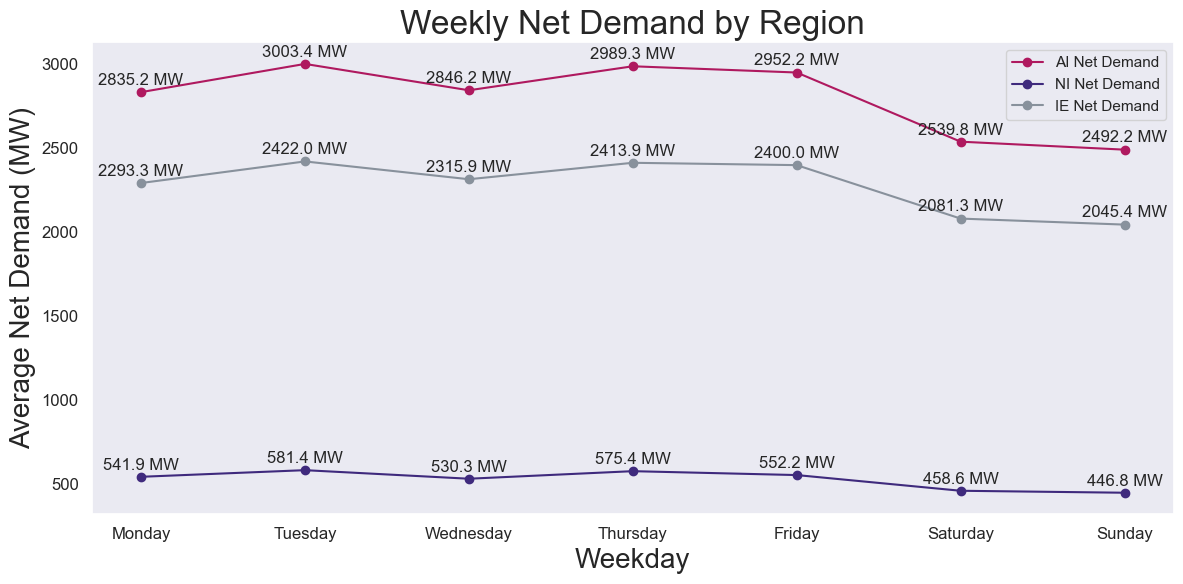

In [18]:
# Calculate the day of the week from 'Trading Day'
df['Trading Day'] = pd.to_datetime(df['Trading Day'])
df['Weekday'] = df['Trading Day'].dt.day_name()

# Define a function to add value annotations
def add_value_annotations(ax, lines):
    for line in lines:
        y_values = line.get_ydata()
        for i, y in enumerate(y_values):
            ax.annotate(f'{y:.1f} MW',
                        xy=(i, y),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

# Reset the index without keeping the column
df.reset_index(drop=True, inplace=True)

# Group by the day of the week and calculate the average Net Demand for each region
avg_net_demand = df.groupby('Weekday')[['AI Net Demand', 'NI Net Demand', 'IE Net Demand']].mean()

# Define an ordered list of weekdays
week_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Reorder the weekdays
avg_net_demand = avg_net_demand.reindex(week_days)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the average Net demand for each region with specified colors
lines_ai = ax.plot(avg_net_demand.index, avg_net_demand['AI Net Demand'], marker='o', color='#af195f', label='AI Net Demand')
lines_ni = ax.plot(avg_net_demand.index, avg_net_demand['NI Net Demand'], marker='o', color='#3F2A7D', label='NI Net Demand')
lines_ie = ax.plot(avg_net_demand.index, avg_net_demand['IE Net Demand'], marker='o', color='#88919C', label='IE Net Demand')


# Add value annotations
add_value_annotations(ax, lines_ai)
add_value_annotations(ax, lines_ni)
add_value_annotations(ax, lines_ie)


# Add labels and title
ax.set_xlabel('Weekday',fontsize=20)
ax.set_ylabel('Average Net Demand (MW)',fontsize=20)
ax.set_title('Weekly Net Demand by Region',fontsize=24)
ax.grid(False)
ax.tick_params(axis='y', labelsize=12) 
ax.tick_params(axis='x', labelsize=12) 
ax.legend()

# Show plot
plt.tight_layout()
plt.show()

# For saving as a JPG
fig.savefig('C:/Users/HP/Desktop/Study/DSA8023/DSA8023 - Bhavana Pansare/weekly_net_demand.jpg', format='jpg');


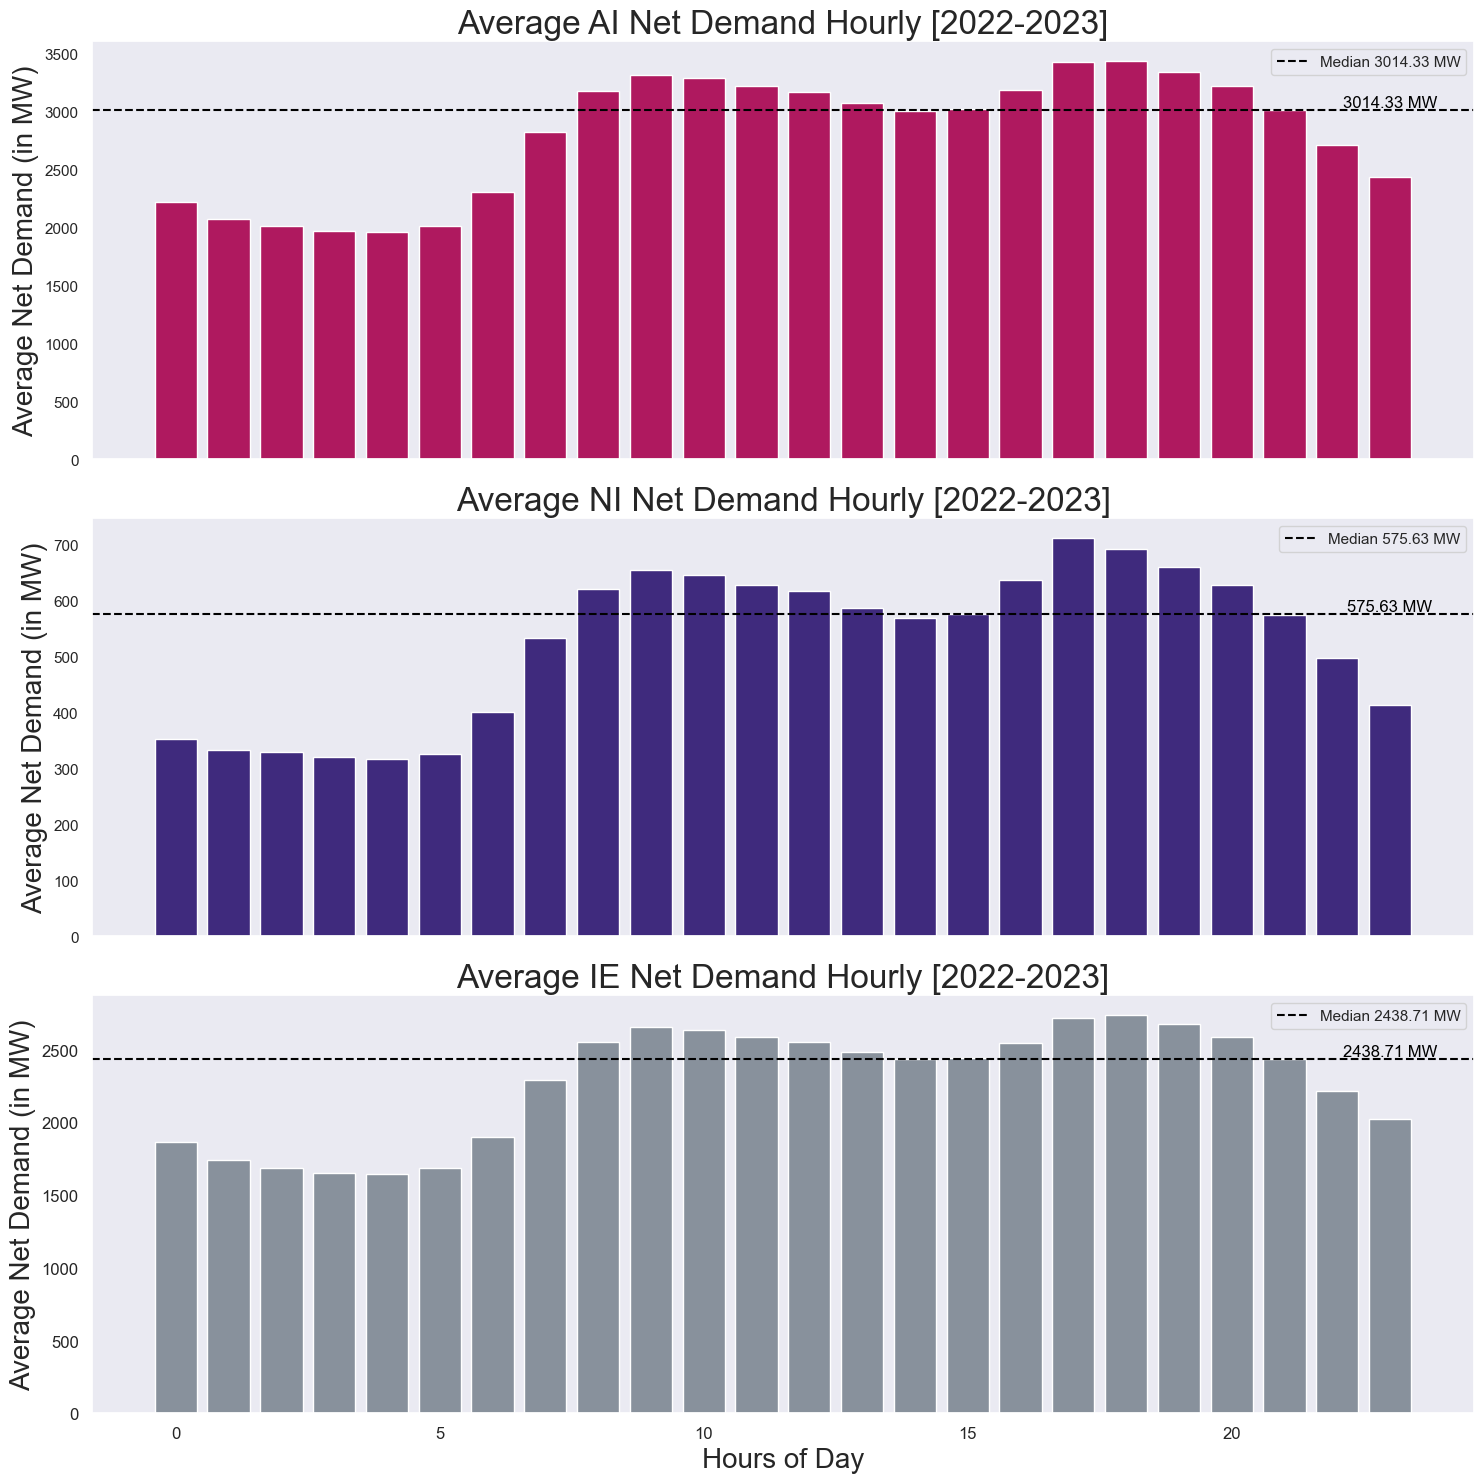

In [19]:
colors = ['#af195f', '#3F2A7D', '#88919C']
# Calculate the hour from 'DateTime'
df['Hour'] = df['DateTime'].dt.hour

# Create subplots for each region
fig, axs = plt.subplots(3, 1, figsize=(15, 15), sharex=True)

# Calculate the average net_demand by hour for each region
for i, region in enumerate(['AI Net Demand', 'NI Net Demand', 'IE Net Demand']):
    avg_net_demand_by_hour = df.groupby('Hour')[region].mean()
    median_value = avg_net_demand_by_hour.median()
    
    # Plotting the bar chart for the region
    bars = axs[i].bar(avg_net_demand_by_hour.index, avg_net_demand_by_hour.values, color=colors[i])
    
    # Drawing the median line
    axs[i].axhline(y=median_value, color='black', linestyle='dashed', label=f'Median {median_value:.2f} MW')
    
    # Add the median value as text on the plot
    axs[i].text(23, median_value, f'{median_value:.2f} MW', color='black', ha='center', va='bottom')
    
    # Set title, labels for each subplot
    axs[i].set_title(f'Average {region.split()[0]} Net Demand Hourly [2022-2023]',fontsize=24)
    axs[i].set_ylabel('Average Net Demand (in MW)',fontsize=20)
    axs[i].grid(False)
    
    # Show the legend
    axs[i].legend()

# Set common x-axis label
axs[-1].set_xlabel('Hours of Day',fontsize=20)

# Set xticks and yticks font size to 12
axs[i].tick_params(axis='x', labelsize=12)
axs[i].tick_params(axis='y', labelsize=12)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

# For saving as a JPG
fig.savefig('C:/Users/HP/Desktop/Study/DSA8023/DSA8023 - Bhavana Pansare/hourly_net_demand.jpg', format='jpg');


### Outliers

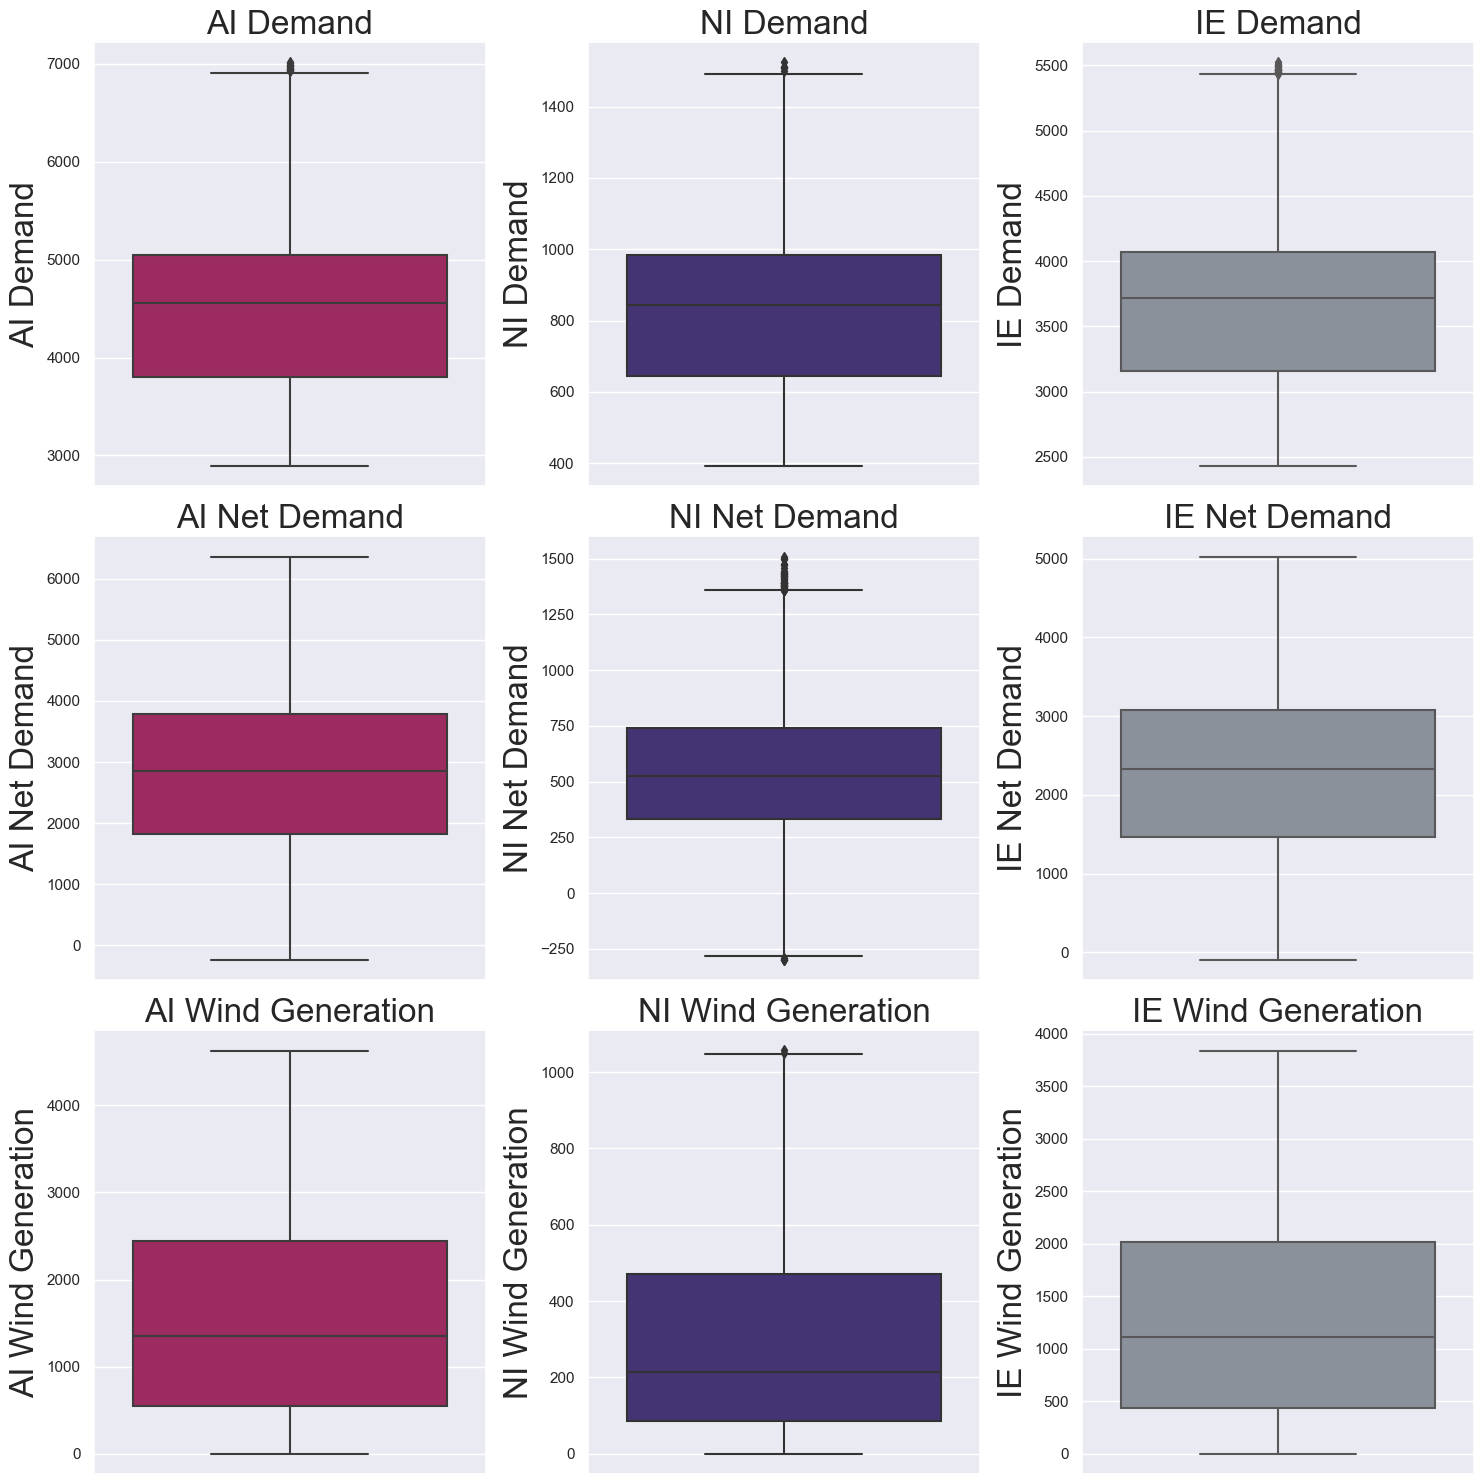

In [20]:
# Figure layout with 3 rows (for Demand, Net Demand, Wind Generation) and 3 columns (for AI, NI, IE)
fig, axs = plt.subplots(3, 3, figsize=(15, 15), sharex='col')

# Define colors for each variable
color_demand = '#af195f'
color_net_demand = '#3F2A7D'
color_wind_gen = '#88919C'

# Plotting Demand (first row)
sns.boxplot(data=df, y='AI Demand', ax=axs[0, 0], color=color_demand)
sns.boxplot(data=df, y='NI Demand', ax=axs[0, 1], color=color_net_demand)
sns.boxplot(data=df, y='IE Demand', ax=axs[0, 2], color=color_wind_gen)
axs[0, 0].set_title('AI Demand',fontsize=24)
axs[0, 1].set_title('NI Demand',fontsize=24)
axs[0, 2].set_title('IE Demand',fontsize=24)
axs[0, 0].set_ylabel('AI Demand',fontsize=24)
axs[0, 1].set_ylabel('NI Demand',fontsize=24)
axs[0, 2].set_ylabel('IE Demand',fontsize=24)

# Plotting Net Demand (second row)
sns.boxplot(data=df, y='AI Net Demand', ax=axs[1, 0], color=color_demand)
sns.boxplot(data=df, y='NI Net Demand', ax=axs[1, 1], color=color_net_demand)
sns.boxplot(data=df, y='IE Net Demand', ax=axs[1, 2], color=color_wind_gen)
axs[1, 0].set_title('AI Net Demand',fontsize=24)
axs[1, 1].set_title('NI Net Demand',fontsize=24)
axs[1, 2].set_title('IE Net Demand',fontsize=24)
axs[1, 0].set_ylabel('AI Net Demand',fontsize=24)
axs[1, 1].set_ylabel('NI Net Demand',fontsize=24)
axs[1, 2].set_ylabel('IE Net Demand',fontsize=24)

# Plotting Wind Generation (third row)
sns.boxplot(data=df, y='AI Wind Generation', ax=axs[2, 0], color=color_demand)
sns.boxplot(data=df, y='NI Wind Generation', ax=axs[2, 1], color=color_net_demand)
sns.boxplot(data=df, y='IE Wind Generation', ax=axs[2, 2], color=color_wind_gen)
axs[2, 0].set_title('AI Wind Generation',fontsize=24)
axs[2, 1].set_title('NI Wind Generation',fontsize=24)
axs[2, 2].set_title('IE Wind Generation',fontsize=24)
axs[2, 0].set_ylabel('AI Wind Generation',fontsize=24)
axs[2, 1].set_ylabel('NI Wind Generation',fontsize=24)
axs[2, 2].set_ylabel('IE Wind Generation',fontsize=24)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

# Adjust font size of xticks and yticks
for ax in axs.flat:
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
# Remove grid lines from all subplots
for i in range(3):
    for j in range(3):
        axs[i, j].grid(False)
# For saving as a JPG
fig.savefig('C:/Users/HP/Desktop/Study/DSA8023/DSA8023 - Bhavana Pansare/outliers.jpg', format='jpg');

### Interconnectors

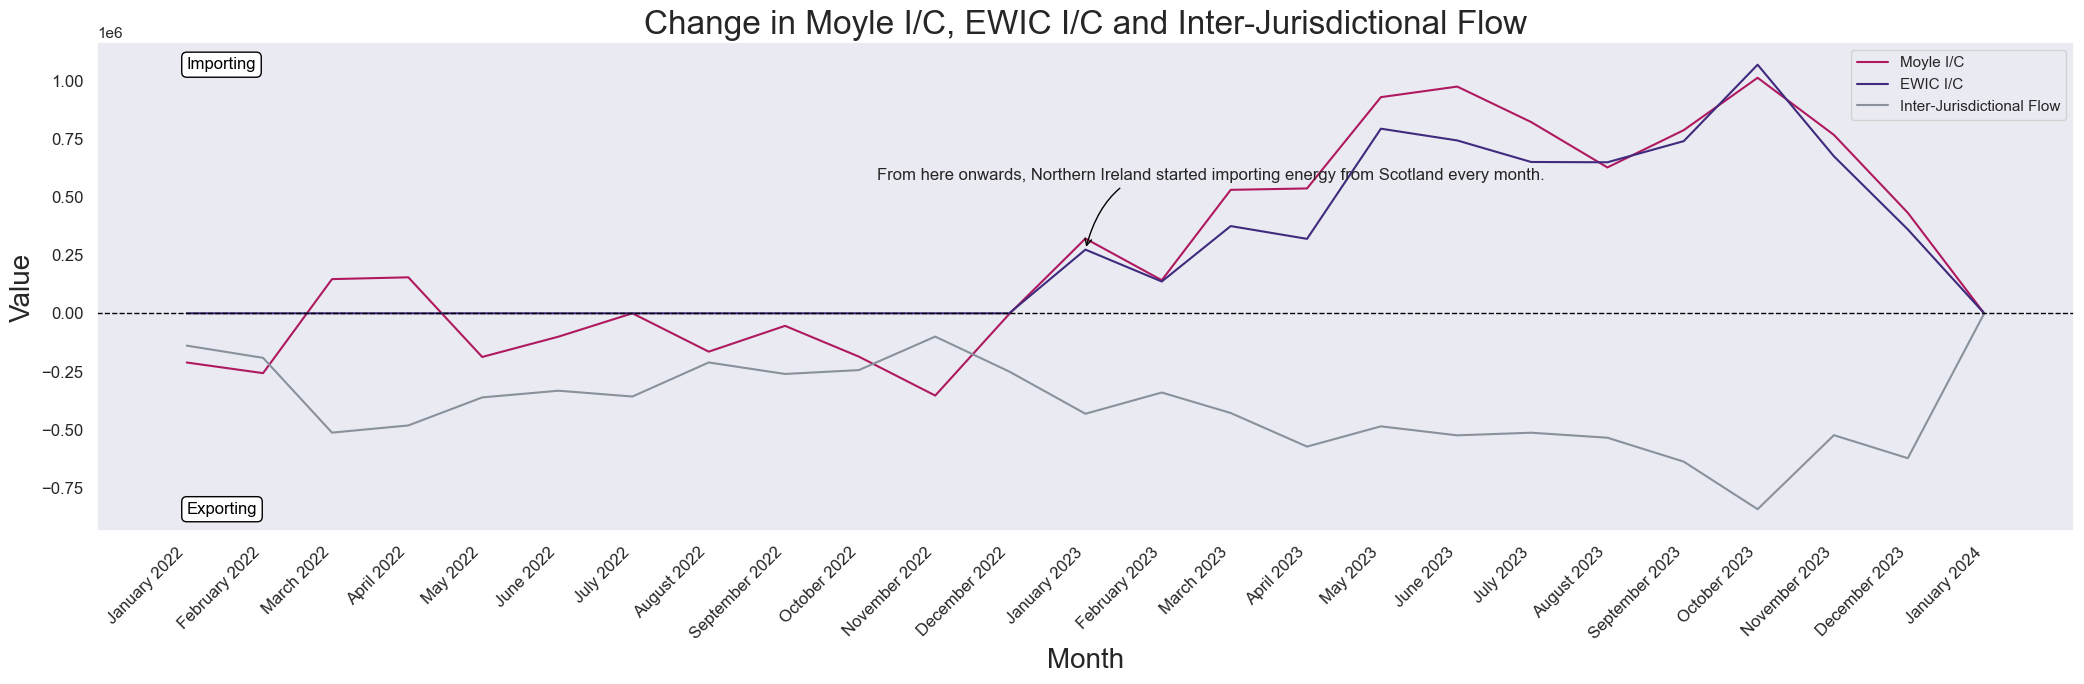

In [21]:
# Convert 'Trading Day' to month and year for plotting
df['MonthYear'] = df['Trading Day'].dt.to_period('M').dt.to_timestamp()

# Aggregate the data by the new 'MonthYear' column for plotting
monthly_data = df.groupby('MonthYear')[['Moyle I/C', 'EWIC I/C', 'Inter-Jurisdictional Flow']].sum()

# Find the breakpoint where EWIC I/C started to increase significantly.
ewic_ic_increase = (monthly_data['EWIC I/C'].diff() > 0.00).astype(int)
breakpoint = ewic_ic_increase.idxmax() if ewic_ic_increase.any() else None

# Plotting the line graphs
fig = plt.figure(figsize=(21, 7))
plt.plot(monthly_data.index, monthly_data['Moyle I/C'], '-r', label='Moyle I/C',color='#af195f')
plt.plot(monthly_data.index, monthly_data['EWIC I/C'], '-g', label='EWIC I/C',color='#3F2A7D')
plt.plot(monthly_data.index, monthly_data['Inter-Jurisdictional Flow'], '-b', label='Inter-Jurisdictional Flow', color='#88919C')

# Annotating the breakpoint
plt.annotate(
    'From here onwards, Northern Ireland started importing energy from Scotland every month.',
    xy=(breakpoint, monthly_data.loc[breakpoint, 'EWIC I/C']),
    xytext=(-150, 50),
    textcoords='offset points',
    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.5', color='black')
)

# Find the maximum y value greater than 0
max_y_value = monthly_data[monthly_data['EWIC I/C'] > 0]['EWIC I/C'].max()

# Add text indicating importing with a box around it
plt.text(
    monthly_data.index[0], 
    max_y_value, 
    'Importing', 
    color='black', 
    ha='left', 
    va='center', 
    fontsize=12, 
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
)

# Find the minimum y value less than 0
min_y_value = monthly_data[monthly_data['Inter-Jurisdictional Flow'] < 0]['Inter-Jurisdictional Flow'].min()

# Add text indicating exporting with a box around it
plt.text(
    monthly_data.index[0], 
    min_y_value, 
    'Exporting', 
    color='black', 
    ha='left', 
    va='center', 
    fontsize=12, 
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
)

# Customize the plot
plt.axhline(0, color='black', linewidth=1, linestyle='--')
plt.title('Change in Moyle I/C, EWIC I/C and Inter-Jurisdictional Flow',fontsize=24)
plt.xlabel('Month', fontsize=20)
plt.ylabel('Value', fontsize=20)
plt.legend()
plt.xticks(monthly_data.index, [month.strftime('%B %Y') for month in monthly_data.index], rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(False)
plt.tight_layout()
plt.show()

# For saving as a JPG
fig.savefig('C:/Users/HP/Desktop/Study/DSA8023/DSA8023 - Bhavana Pansare/interconnectors.jpg', format='jpg');

### Data Preparation

In [22]:
# Reordering and selecting specific columns in the DataFrame 'df'.
# Only include the listed columns in the specified order and exclude rest of columns.
df = df[['DateTime', 'NI Generation', 'NI Demand', 'NI Wind Generation', 'NI Solar Generation',
       'IE Generation', 'IE Demand', 'IE Wind Generation', 'IE Solar Generation', 'IE Hydro',
       'AI Generation', 'AI Demand', 'AI Wind Generation', 'AI Solar Generation', 'AI Hydro',
        'AI Net Demand','IE Net Demand', 'NI Net Demand','Trading Day', 'hour','min']]

In [23]:
# Print the column names of the DataFrame
df.columns

Index(['DateTime', 'NI Generation', 'NI Demand', 'NI Wind Generation',
       'NI Solar Generation', 'IE Generation', 'IE Demand',
       'IE Wind Generation', 'IE Solar Generation', 'IE Hydro',
       'AI Generation', 'AI Demand', 'AI Wind Generation',
       'AI Solar Generation', 'AI Hydro', 'AI Net Demand', 'IE Net Demand',
       'NI Net Demand', 'Trading Day', 'hour', 'min'],
      dtype='object')

In [24]:
# Aggregating data by 'Trading Day', 'hour', and 'min' to summarize into finer time slots.
_30_min_df = df.groupby(['Trading Day', 'hour', 'min']).agg({
    'AI Demand':'sum', # Sum of 'AI Demand' for each group
    'AI Wind Generation':'sum', # Sum of 'AI Wind Generation' for each group
    'AI Net Demand':'sum', # Sum of 'AI Net Demand' for each group
    'IE Demand':'sum', # Sum of 'IE Demand' for each group
    'IE Wind Generation':'sum', # Sum of 'IE Wind Generation' for each group
    'IE Net Demand':'sum', # Sum of 'IE Net Demand' for each group
    'NI Demand':'sum', # Sum of 'NI Demand' for each group
    'NI Wind Generation':'sum', # Sum of 'NI Wind Generation' for each group
    'NI Net Demand':'sum' # Sum of 'NI Net Demand' for each group
}).reset_index()

In [25]:
# Display the first 5 rows of the DataFrame
_30_min_df.head()

,Trading Day,hour,min,AI Demand,AI Wind Generation,AI Net Demand,IE Demand,IE Wind Generation,IE Net Demand,NI Demand,NI Wind Generation,NI Net Demand
0,2022-01-01,0,First 30,7428.67,6249.48,866.99,6248.49,5056.78,879.51,1180.18,1192.70,-12.52
1,2022-01-01,0,Second 30,7198.91,6207.24,680.65,6076.63,5007.42,758.19,1122.28,1199.82,-77.54
2,2022-01-01,1,First 30,7064.98,6523.32,229.31,5925.86,5271.76,341.75,1139.12,1251.56,-112.44
3,2022-01-01,1,Second 30,6822.09,6275.02,234.22,5725.94,4986.94,426.15,1096.15,1288.08,-191.93
4,2022-01-01,2,First 30,6597.07,6184.99,98.89,5565.45,4892.08,360.18,1031.62,1292.91,-261.29


In [26]:
# Create a multi-index by combining 'Trading Day' with 'hour' and 'min'
multi_index = pd.MultiIndex.from_arrays([
    _30_min_df['Trading Day'],
    _30_min_df['hour'].astype(str) + ':' + _30_min_df['min'].astype(str)
], names=['Trading Day', 'Time'])

# Create a new DataFrame with this multi-index
multi_level_df = _30_min_df.set_index(multi_index)

# Drop the 'Trading Day', 'hour', and 'min' columns as they are now in the index
multi_level_df = multi_level_df.drop(['Trading Day', 'hour', 'min'], axis=1)

# Pivoting data for a wide-format view by time slot.
_30_min_pivoted_df = multi_level_df.unstack(level='Time')

# Flatten the MultiIndex columns
_30_min_pivoted_df.columns = [' '.join(col).strip() for col in _30_min_pivoted_df.columns.values]

# Resetting index to revert 'Trading Day' to a column.
_30_min_pivoted_df.reset_index(inplace=True)

In [27]:
# Fill NaN values in all columns (except the first one) with the column mean
_30_min_pivoted_df = _30_min_pivoted_df.fillna(_30_min_pivoted_df.iloc[:,1:].mean())
# Limit the DataFrame to the first 730 rows, retaining all columns
#(because it was for 1st January 2024 and we have to ignore that value as we have to consider only 2 year of data)
_30_min_pivoted_df = _30_min_pivoted_df.iloc[:730,:]


In [28]:
# Initialize a MinMaxScaler object
mm = MinMaxScaler()
# Scale all columns except the first one(Trading Day) using MinMaxScaler and update the DataFrame
_30_min_pivoted_df.iloc[:,1:] = mm.fit_transform(_30_min_pivoted_df.iloc[:,1:])
# Create a copy of the scaled DataFrame for clustering or other analyses
_30_min_clusters_df = _30_min_pivoted_df.copy()

In [29]:
# Printing the shape of Dataframe
_30_min_clusters_df.shape

(730, 433)

## Similarity Algorithms Implementation for non-clustered datasets:

In [30]:
# This function finds the most similar days to the provided record
def find_similar_days(input_record_scaled, df, date_col='Trading Day', top_n=10):
    # Validation - Checking the input type and print a message if it's not ndarray or Series
    if not isinstance(input_record_scaled, (np.ndarray, pd.Series)):
        print("Please ensure the input is either a numpy ndarray or a pandas Series.")
        return 

    # Compute cosine similarity scores between the input record and all records in the DataFrame
    similarity_scores = cosine_similarity([input_record_scaled], df.iloc[:,1:])[0]

    # Sort the indices of these scores to get the top 10 highest scores (most similar)
    top_indices = similarity_scores.argsort()[-top_n:][::-1]
    # Sort the indices of these scores to get the last 10 highest scores (most similar)
    #top_indices = similarity_scores.argsort()[:top_n]

    # Returns the dates for the top 10 most similar records
    similar_days = df.iloc[top_indices][date_col].tolist()
    # Extract the top 10 similarity scores with the help of sorted index
    similar_scores = similarity_scores[top_indices]

    # Converting the similarity scores to percentage
    similar_scores_percentage = [f"{score:.2%}" for score in similar_scores]
    # Combine the each similar day with its corresponding similarity score for output
    similar_days_with_scores = list(zip(similar_days, similar_scores_percentage))

    # Print the similar days and their scores, indicating the degree of similarity
    for day, score in similar_days_with_scores:
        day = pd.to_datetime(day).date() 
        print(f"Record is {score} similar to the input on day {day}")
    return similar_days_with_scores

In [31]:
# Validation Test Case
# Generating a list of 432 random values between 0 and 1
input_record_scaled = np.random.rand(432).tolist()

# Calling the function to get the most similar days
find_similar_days(input_record_scaled,_30_min_pivoted_df)

Please ensure the input is either a numpy ndarray or a pandas Series.


In [32]:
# Generate a series of 432 random values between 0 and 1
input_record_scaled = np.random.rand(432)

# Calling the function to retrive the most similar days
similar_days_results = find_similar_days(input_record_scaled, _30_min_pivoted_df)
# Export the results to a CSV file
similar_days_df = pd.DataFrame(similar_days_results, columns=['Date', 'Similarity'])
similar_days_df.to_csv('C:/Users/HP/Desktop/Study/DSA8023/DSA8023 - Bhavana Pansare/random_similar_days_results.csv', index=False)

Record is 83.99% similar to the input on day 2023-04-19
Record is 83.68% similar to the input on day 2023-06-23
Record is 83.63% similar to the input on day 2022-04-21
Record is 83.62% similar to the input on day 2022-12-04
Record is 83.57% similar to the input on day 2023-02-06
Record is 83.35% similar to the input on day 2023-02-21
Record is 83.33% similar to the input on day 2023-02-03
Record is 83.30% similar to the input on day 2022-03-22
Record is 83.17% similar to the input on day 2023-02-10
Record is 83.13% similar to the input on day 2023-03-30


In [33]:
# Capture the start time
start_time = time.time()
# Call find_similar_days using the 570th row (i.e Trading Date:2023-07-25)
similar_days_results = find_similar_days(_30_min_pivoted_df.iloc[570,1:], _30_min_pivoted_df)
# Capture the stop time
stop_time = time.time()
# Calculate and print the elapsed time in the format Hours:Minutes:Seconds
print('Elapsed Time:',time.strftime("%H:%M:%S", time.gmtime(stop_time - start_time)))
# Export the results to a CSV file
similar_days_df = pd.DataFrame(similar_days_results, columns=['Date', 'Similarity'])
similar_days_df.to_csv('C:/Users/HP/Desktop/Study/DSA8023/DSA8023 - Bhavana Pansare/existing_similar_days_results.csv', index=False)

Record is 100.00% similar to the input on day 2023-07-25
Record is 99.70% similar to the input on day 2023-06-20
Record is 99.65% similar to the input on day 2023-06-13
Record is 99.59% similar to the input on day 2023-09-01
Record is 99.58% similar to the input on day 2023-06-21
Record is 99.57% similar to the input on day 2022-06-23
Record is 99.56% similar to the input on day 2022-08-09
Record is 99.56% similar to the input on day 2022-06-02
Record is 99.55% similar to the input on day 2023-08-16
Record is 99.49% similar to the input on day 2022-08-11
Elapsed Time: 00:00:00


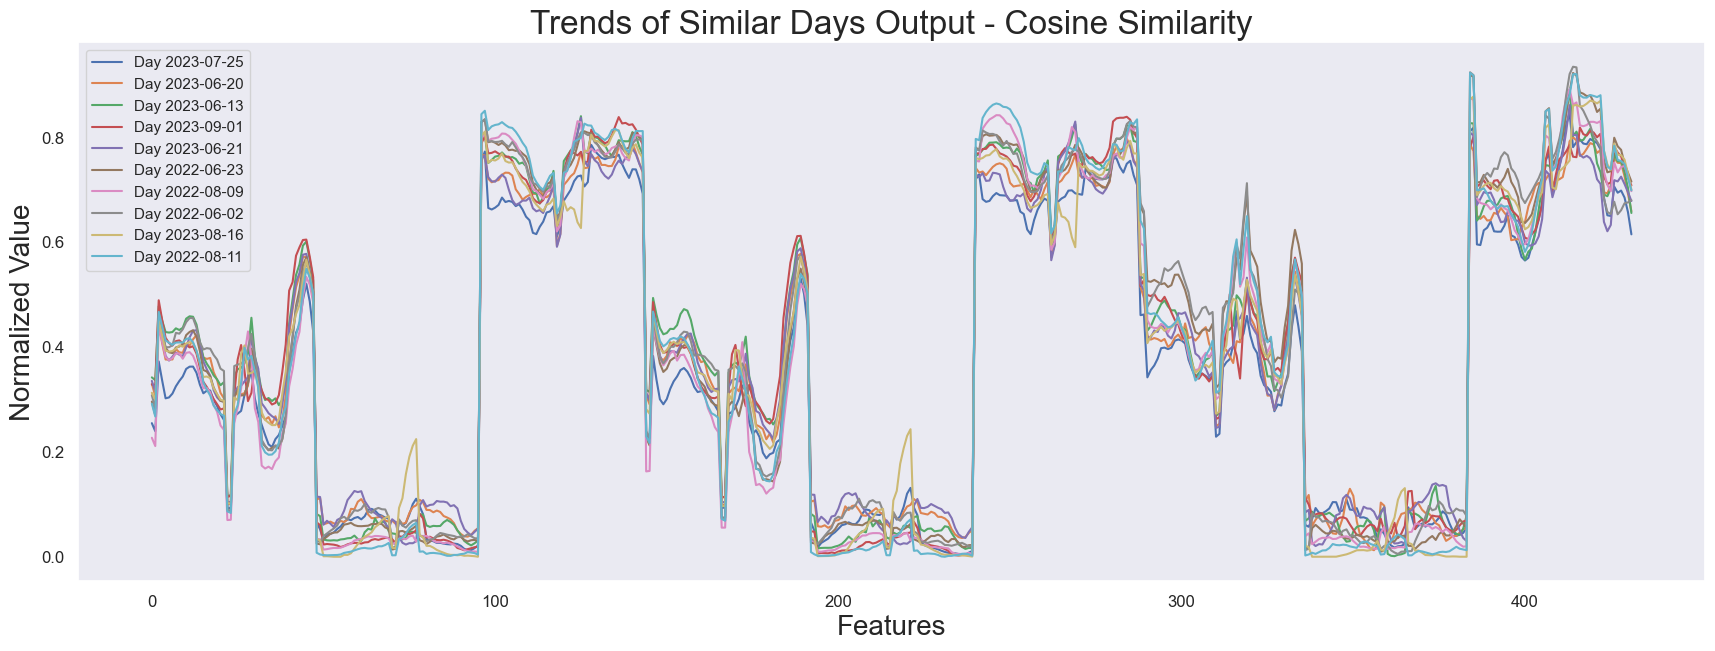

In [34]:
# Extract just the dates from the results
similar_days_dates = [result[0] for result in similar_days_results]
similar_days_dates = [pd.Timestamp(date).date() for date in similar_days_dates]

# Make sure the 'Trading Day' column is of type datetime
_30_min_pivoted_df['Trading Day'] = pd.to_datetime(_30_min_pivoted_df['Trading Day'])

# Get the data for these dates
similar_days_data = []
for date in similar_days_dates:
    # Extract data for the given date
    mask = _30_min_pivoted_df['Trading Day'].dt.date == date
    if any(mask):
        day_data = _30_min_pivoted_df.loc[mask].drop('Trading Day', axis=1).values.flatten()
        similar_days_data.append(day_data)
    else:
        # If no data for this date, append an empty array for consistency
        similar_days_data.append(np.array([]))

# Plot the data for the similar days
fig = plt.figure(figsize=(21, 7))  

# Plot each day's data points on single graph
for i, day_data in enumerate(similar_days_data):
    if day_data.size > 0: 
        plt.plot(day_data, label=f'Day {similar_days_dates[i]}')
    else:
        # Print a message if there's no data for this date
        print(f"No data found for {similar_days_dates[i]}")

plt.legend()
plt.title('Trends of Similar Days Output - Cosine Similarity',fontsize=24)
plt.xlabel('Features',fontsize=20)
plt.ylabel('Normalized Value',fontsize=20)
plt.grid(False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

# For saving as a JPG
fig.savefig('C:/Users/HP/Desktop/Study/DSA8023/DSA8023 - Bhavana Pansare/similarity_result.jpg', format='jpg');

## Kmeans Algorithm

In [35]:
# KMeans Clustering Algorithm Implementation
def kmeans_algorithm_implementation(X):
    SSE = []
    silhouette_avg = []

    # Looping over the number of clusters
    for k in range(2, 11):
        # Running KMeans on cluster values from 2 to 10
        kmeans = KMeans(n_clusters=k, random_state=569)
        kmeans.fit(X)
        
        # Computing the sum of squared errors (SSE)
        SSE.append(kmeans.inertia_)
        
        # Computing the silhouette score
        labels = kmeans.labels_
        score = silhouette_score(X, labels)
        silhouette_avg.append(score)

    # Plotting the values of SSE
    plt.figure(figsize=(10, 5))
    plt.plot(range(2, 11), SSE, marker='o')
    plt.title('The Elbow Method - KMeans Clustering', fontsize=24, fontweight='bold')
    plt.xlabel('Number of Clusters', fontsize=20, fontweight='bold')
    plt.ylabel('Sum of Squared Errors (SSE)', fontsize=20, fontweight='bold')
    plt.grid(False)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

    # Plotting the Silhouette analysis
    plt.figure(figsize=(10, 5))
    plt.plot(range(2, 11), silhouette_avg, marker='o')
    plt.title('Silhouette Analysis For Optimal k - KMeans Clustering', fontsize=24, fontweight='bold')
    plt.xlabel('Number of Clusters', fontsize=20, fontweight='bold')
    plt.ylabel('Silhouette Score', fontsize=20, fontweight='bold')
    plt.grid(False)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()


In [36]:
# Display the first 5 rows of the DataFrame excluding the first column
_30_min_pivoted_df.iloc[:,1:].head()

,AI Demand 0:First 30,AI Demand 0:Second 30,AI Demand 10:First 30,AI Demand 10:Second 30,AI Demand 11:First 30,AI Demand 11:Second 30,AI Demand 12:First 30,AI Demand 12:Second 30,AI Demand 13:First 30,AI Demand 13:Second 30,...,NI Net Demand 5:First 30,NI Net Demand 5:Second 30,NI Net Demand 6:First 30,NI Net Demand 6:Second 30,NI Net Demand 7:First 30,NI Net Demand 7:Second 30,NI Net Demand 8:First 30,NI Net Demand 8:Second 30,NI Net Demand 9:First 30,NI Net Demand 9:Second 30
0,0.31,0.30,0.00,0.00,0.00,0.05,0.11,0.17,0.21,0.23,...,0.22,0.18,0.14,0.17,0.18,0.18,0.17,0.12,0.13,0.12
1,0.18,0.15,0.10,0.10,0.09,0.12,0.17,0.20,0.23,0.24,...,0.28,0.25,0.20,0.23,0.23,0.22,0.21,0.12,0.12,0.06
2,0.20,0.17,0.22,0.22,0.20,0.23,0.27,0.32,0.35,0.37,...,0.59,0.53,0.29,0.23,0.22,0.18,0.19,0.21,0.24,0.27
3,0.40,0.39,0.65,0.65,0.65,0.66,0.68,0.70,0.72,0.71,...,0.40,0.26,0.24,0.34,0.40,0.38,0.45,0.44,0.47,0.48
4,0.62,0.60,0.78,0.79,0.79,0.81,0.82,0.83,0.84,0.82,...,0.68,0.62,0.61,0.63,0.76,0.78,0.81,0.82,0.81,0.84


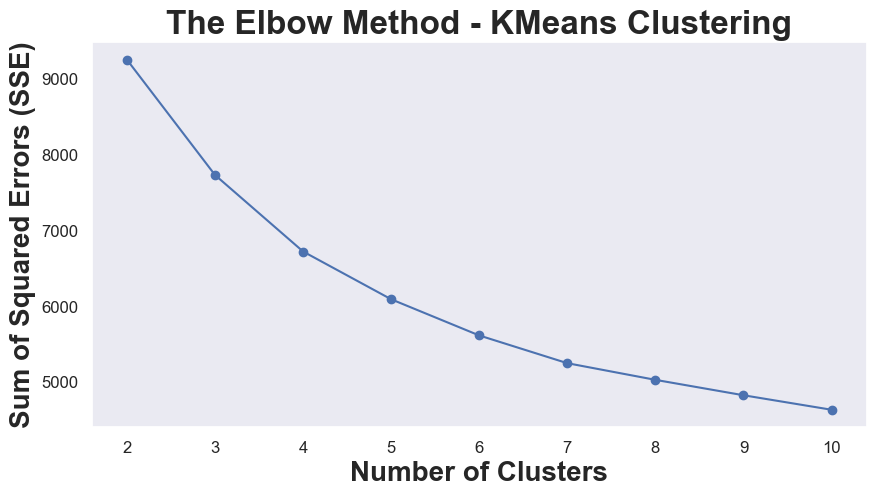

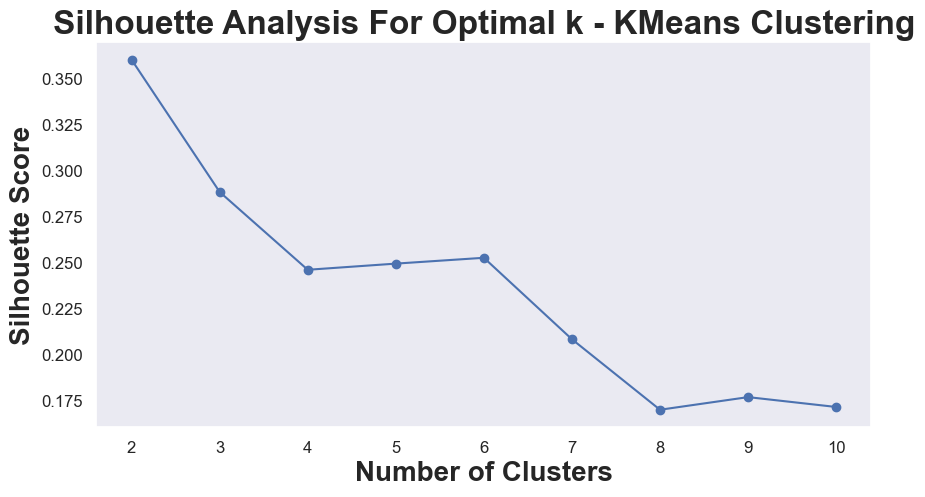

In [37]:
# Initialize MinMaxScaler to scale the data to a range between 0 and 1
mm = MinMaxScaler()
# Scale all columns except the first (Trading Day is non-numeric) of _30_min_pivoted_df
_30_min_pivoted_df.iloc[:,1:] = mm.fit_transform(_30_min_pivoted_df.iloc[:,1:])
# Passed the scaled data to the KMeans clustering function
kmeans_algorithm_implementation(_30_min_pivoted_df.iloc[:,1:])

## Similarity Algorithm Implementation for Clustered Datasets:

In [38]:
# Function to find the most similar days to the input record
def find_similar_days_clustered_data(input_record_scaled, date_col='Trading Day', top_n=10):
    # Cloning the dataset
    cloned_data = _30_min_clusters_df.copy() 
    
    # Validation - Checking the input type and print a message if it's not ndarray or Series
    if not isinstance(input_record_scaled, (np.ndarray, pd.Series)):
        print("Please ensure the input is either a numpy ndarray or a pandas Series.")
        return 
    
    # Handle input record formatting based on its type
    if type(input_record_scaled) == np.ndarray:
        df_np = pd.DataFrame(input_record_scaled.reshape(1, -1))  # Reshape to a row DataFrame
    elif type(input_record_scaled) == pd.Series: # For Series data
        df_np = pd.DataFrame(input_record_scaled).transpose()

    # Added a 'Date' column at the beginning of the DataFrame
    date = '2024-04-02'
    df_np.insert(0, 'Date', date)

    # Rename columns to match the existing DataFrame
    df_np.columns = ['Date'] + [f'Field_{i}' for i in range(1, 433)]
    df_np.columns = cloned_data.columns
    cloned_data = pd.concat([cloned_data, df_np], ignore_index=True)
    cloned_data

    # Performing the KMeans clustering on the dataset excluding the 'Date' column
    kmeans = KMeans(n_clusters=4, random_state=569)
    y_predict = kmeans.fit_predict(cloned_data.iloc[:,1:])

    # Assigning the cluster values to the dataset
    cloned_data['kmeans_cluster'] = y_predict

    # Select subset of data belongs to the same cluster as the input record
    data_subset = cloned_data[cloned_data['kmeans_cluster'] == cloned_data.iloc[-1,-1]]

    # Calculate the cosine similarity between the input record and subset data
    similarity_scores = cosine_similarity([data_subset.iloc[-1,1:]], data_subset.iloc[:-1,1:])[0]

    # Identify top 10 most similar records based on similarity scores
    top_indices = similarity_scores.argsort()[-top_n:][::-1]

    # Extract dates and similarity scores for the most similar records
    similar_days = data_subset.iloc[top_indices][date_col].tolist()
    similar_scores = similarity_scores[top_indices]

    # Convert the similarity scores into percentages
    similar_scores_percentage = [f"{score:.2%}" for score in similar_scores]
    # Combine the result together into dates and scores for output
    similar_days_with_scores = list(zip(similar_days, similar_scores_percentage))

    # Create a DataFrame from the results
    similar_days_df = pd.DataFrame(similar_days_with_scores, columns=['Date', 'Similarity'])
    # Print similar days and their similarity to the input record
    for day, score in similar_days_with_scores:
        day = pd.to_datetime(day).date() 
        print(f"Record is {score} similar to the input on day {day}")
    return similar_days_df


In [39]:
# Validation Test Case
# Generating a list of 432 random values between 0 and 1
input_record_scaled = np.random.rand(432).tolist()

# Calling the function to get the most similar days
find_similar_days_clustered_data(input_record_scaled)

Please ensure the input is either a numpy ndarray or a pandas Series.


In [40]:
# Generating a ndarray of 432 random values between 0 and 1
input_record_scaled = np.random.rand(432)

# Calling the function to get the most similar days
similar_days_results = find_similar_days_clustered_data(input_record_scaled)
# Exporting the DataFrame to a CSV file
similar_days_results.to_csv('C:/Users/HP/Desktop/Study/DSA8023/DSA8023 - Bhavana Pansare/random_similar_days_cluster_results.csv', index=False)

Record is 85.28% similar to the input on day 2023-04-19
Record is 84.71% similar to the input on day 2023-10-23
Record is 84.23% similar to the input on day 2022-12-04
Record is 84.22% similar to the input on day 2022-03-21
Record is 84.15% similar to the input on day 2023-10-03
Record is 84.01% similar to the input on day 2023-03-30
Record is 83.90% similar to the input on day 2022-01-23
Record is 83.86% similar to the input on day 2022-04-21
Record is 83.78% similar to the input on day 2023-02-06
Record is 83.74% similar to the input on day 2023-06-08


In [41]:
# Capture the start time
start_time = time.time()
# Call find_similar_days_clustered_data using the 570th row (i.e Trading Date:2023-07-25)
similar_days_results =  find_similar_days_clustered_data(_30_min_clusters_df.iloc[570,1:])
# Capture the stop time
stop_time = time.time()
# Calculate and print the elapsed time in the format Hours:Minutes:Seconds
print('Elapsed Time:',time.strftime("%H:%M:%S", time.gmtime(stop_time - start_time)))

# Exporting the DataFrame to a CSV file
similar_days_results.to_csv('C:/Users/HP/Desktop/Study/DSA8023/DSA8023 - Bhavana Pansare/existing_similar_days_cluster_results.csv', index=False)

Record is 100.00% similar to the input on day 2023-07-25
Record is 99.70% similar to the input on day 2023-06-20
Record is 99.65% similar to the input on day 2023-06-13
Record is 99.59% similar to the input on day 2023-06-21
Record is 99.59% similar to the input on day 2023-09-01
Record is 99.57% similar to the input on day 2022-08-09
Record is 99.56% similar to the input on day 2022-06-23
Record is 99.56% similar to the input on day 2023-08-16
Record is 99.55% similar to the input on day 2022-06-02
Record is 99.50% similar to the input on day 2023-08-08
Elapsed Time: 00:00:00


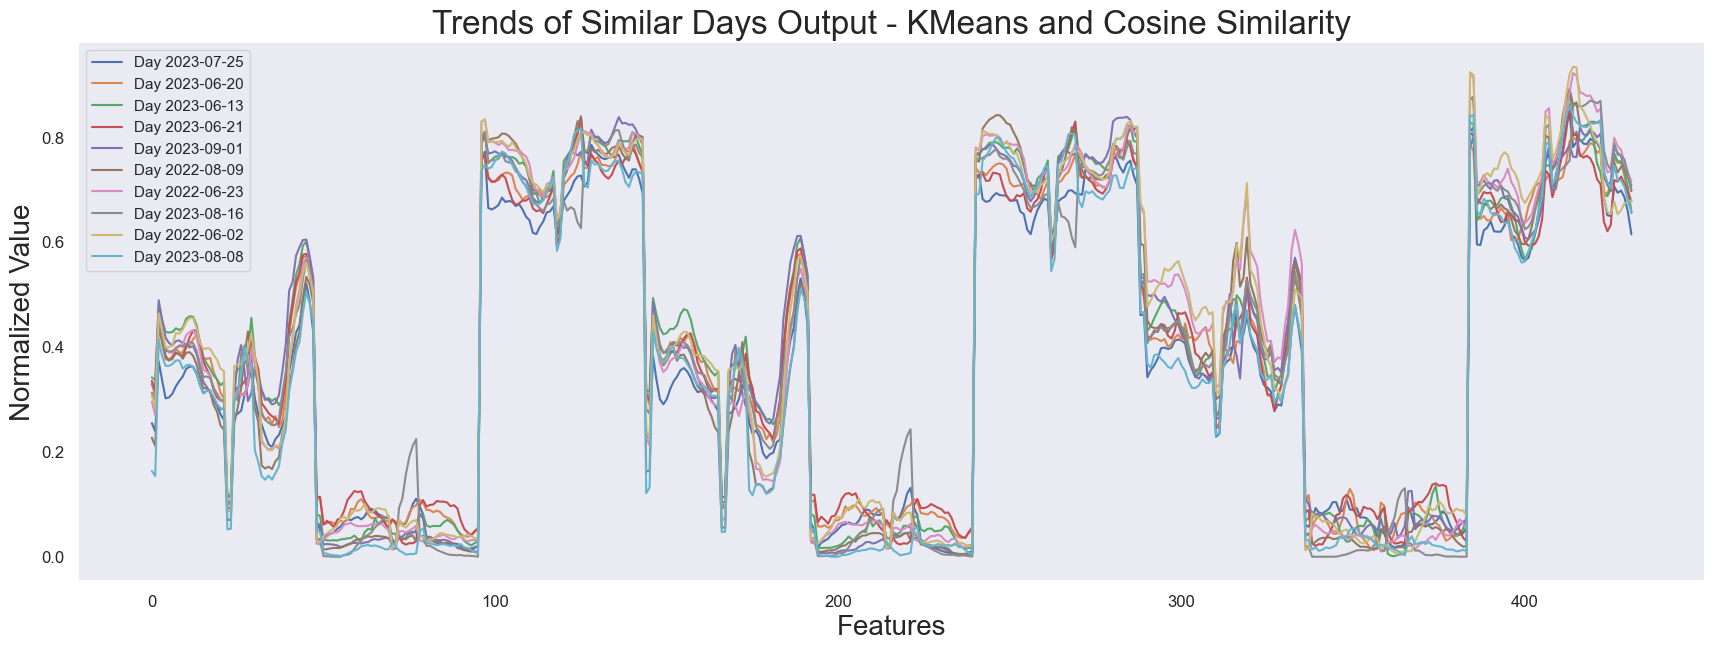

In [42]:
# Extract just the dates from the results
similar_days_dates = []

for result in similar_days_results['Date']:
    date = result
    try:
        date = pd.Timestamp(date).date()
        similar_days_dates.append(date)
    except Exception as e:
        print(f"Error processing date {date}: {e}")

# Make sure the 'Trading Day' column is of type datetime
_30_min_clusters_df['Trading Day'] = pd.to_datetime(_30_min_clusters_df['Trading Day'])

# Get the data for these dates
similar_days_data = []
for date in similar_days_dates:
    # Extract data for the given date
    mask = _30_min_clusters_df['Trading Day'].dt.date == date
    if any(mask):
        day_data = _30_min_clusters_df.loc[mask].drop('Trading Day', axis=1).values.flatten()
        similar_days_data.append(day_data)
    else:
        # If no data for this date, append an array of NaNs for consistency
        similar_days_data.append(np.full((_30_min_clusters_df.shape[1] - 1,), np.nan))

# Plot the data for the similar days
fig = plt.figure(figsize=(21, 7))

# Plot each day's data points on the same graph
for i, day_data in enumerate(similar_days_data):
    if not np.isnan(day_data).all():
        plt.plot(day_data, label=f'Day {similar_days_dates[i]}')
    else:
        # Print a message if there's no data for this date
        print(f"No data found for {similar_days_dates[i]}")

plt.legend() 
plt.title('Trends of Similar Days Output - KMeans and Cosine Similarity',fontsize=24)
plt.xlabel('Features',fontsize=20)
plt.ylabel('Normalized Value',fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(False)
plt.show()

# For saving as a JPG
fig.savefig('C:/Users/HP/Desktop/Study/DSA8023/DSA8023 - Bhavana Pansare/kmeans_cluster_result.jpg', format='jpg');